# Evaporative cooling regulates leaf temperature and respiration in dryland vegetation

Submitted to Agricultural and Forest Meteorology
<br>
Contact: Christopher Kibler, kibler@ucsb.edu

# Load Packages

In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
from scipy import constants
import statsmodels.formula.api as smf
import seaborn as sns
import xarray as xr

In [2]:
from flux_functions import preprocessAmeriflux
from resistance_functions import *
from leaf_temp_functions import *
from respiration_arrhenius import *
from calcBias import calcBias

# Leaf Energy Balance Model

## Calculate Sensitivity Curves

In [3]:
LEB_raw_values = [(ef, rn, rah) for ef in np.arange(0, 1, 0.01) for rn in [250, 500, 750] for rah in [1, 10, 20, 30, 40]]
LEB_input_values = pd.DataFrame(LEB_raw_values).rename(columns = {0:'ef', 1:'rn', 2:'rah'})
LEB_input_values['TL_TA'] = calc_tl_ta(rn = LEB_input_values.rn, rah = LEB_input_values.rah, ef = LEB_input_values.ef, rho = 1.006, cp = 1010)

## Plot Sensitivity Curves

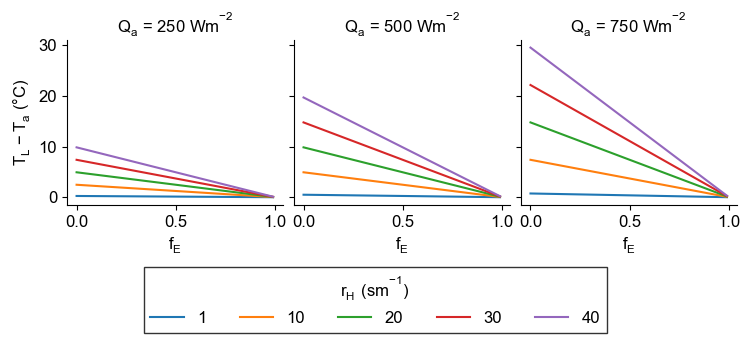

In [4]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)
plt.rc('axes', titlesize=12)

TL_TA_LEB_plot = sns.relplot(data = LEB_input_values, x = 'ef', y = 'TL_TA', col = 'rn', hue = 'rah', kind = 'line', palette = "tab10")
TL_TA_LEB_plot.fig.set_size_inches(190 / constants.inch /1000, 190 / constants.inch /1000 * (0.4))
TL_TA_LEB_plot.set(xlabel = '$\mathregular{f_E}$', ylabel = '$\mathregular{T_L-T_a}$ (°C)')
handles = TL_TA_LEB_plot._legend_data.values()
labels = TL_TA_LEB_plot._legend_data.keys()
sns.move_legend(TL_TA_LEB_plot, "lower center", ncol = 5, frameon = True, fancybox = False, edgecolor = 'black')
TL_TA_LEB_plot._legend.set_title('$\mathregular{r_{H}\ (sm^{-1})}$')
TL_TA_LEB_plot.fig.subplots_adjust(top=1, bottom=0.45)

for col_key,ax in TL_TA_LEB_plot.axes_dict.items():
    ax.set_title("$\mathregular{Q_a}$ = " +  f"{col_key} " + "$\mathregular{Wm^{-2}}$")

In [5]:
TL_TA_LEB_plot.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\sensitivity_curves.pdf', bbox_inches = 'tight')

# Prepare Eddy Covariance Data

### Charleston Mesquite Woodland

In [6]:
#Preprocess Ameriflux dataframe
CMW_Eddy_Covariance_daytime = preprocessAmeriflux('CMW/AMF_US-CMW_BASE_HH_1-5.csv', 
                                                  heights = 3, 
                                                  ustar_thresh = 0.2, 
                                                  time_start = "8:00", 
                                                  time_end = "15:30", 
                                                  time_zone = 'America/Phoenix')

#Calculate TC-TA
CMW_Eddy_Covariance_daytime['IR_tc_ta'] = (CMW_Eddy_Covariance_daytime.T_CANOPY_1_1_1 + 273.15) - (CMW_Eddy_Covariance_daytime.TA_1_2_1 + 273.15)

#Calculate aerodynamic resistance to H following Thom (1972)
CMW_Eddy_Covariance_daytime['opt_rha'] = rha_from_thom_1972(USTAR_col = CMW_Eddy_Covariance_daytime.USTAR, U_col = CMW_Eddy_Covariance_daytime.WS_1_2_1)

#Predict TL-TA from flux data
CMW_Eddy_Covariance_daytime['tc_ta_pred'] = calc_tc_ta(rn = CMW_Eddy_Covariance_daytime.NETRAD, 
                                                         le = CMW_Eddy_Covariance_daytime.LE, 
                                                         g = CMW_Eddy_Covariance_daytime.G, 
                                                         rah = CMW_Eddy_Covariance_daytime.opt_rha, 
                                                         rho = CMW_Eddy_Covariance_daytime.rho, 
                                                         cp = CMW_Eddy_Covariance_daytime.cp)

#Predict TL from flux data
CMW_Eddy_Covariance_daytime['tc_pred'] = ((CMW_Eddy_Covariance_daytime.TA_1_2_1 + 273.15) + CMW_Eddy_Covariance_daytime.tc_ta_pred) - 273.15

#Filter by year
CMW_Eddy_Covariance_daytime = CMW_Eddy_Covariance_daytime[CMW_Eddy_Covariance_daytime.year < 2007]

#Drop observations that do not have complete records for variables needed to predict TL
CMW_Eddy_Covariance_daytime = CMW_Eddy_Covariance_daytime.dropna(subset = ['T_CANOPY_1_1_1', 'Rn_G', 'Evap_Frac', 'opt_rha', 'TA_1_2_1'])

#7371 rows

Check that calculations are the same in K and C

In [7]:
CMW_tc_ta_K = (CMW_Eddy_Covariance_daytime.T_CANOPY_1_1_1 + 273.15) - (CMW_Eddy_Covariance_daytime.TA_1_2_1 + 273.15)
CMW_tc_ta_C = CMW_Eddy_Covariance_daytime.T_CANOPY_1_1_1 - CMW_Eddy_Covariance_daytime.TA_1_2_1

In [8]:
np.all(np.isclose(CMW_tc_ta_K, CMW_tc_ta_C, atol = 1e-9))

True

In [9]:
np.max(CMW_tc_ta_C - CMW_tc_ta_K)

5.684341886080802e-14

In [10]:
CMW_tc_pred_K = ((CMW_Eddy_Covariance_daytime.TA_1_2_1 + 273.15) + CMW_Eddy_Covariance_daytime.tc_ta_pred) - 273.15
CMW_tc_pred_C = CMW_Eddy_Covariance_daytime.TA_1_2_1 + CMW_Eddy_Covariance_daytime.tc_ta_pred

In [11]:
np.all(np.isclose(CMW_tc_pred_K, CMW_tc_pred_C, atol = 1e-9))

True

In [12]:
np.max(CMW_tc_pred_K - CMW_tc_pred_C)

5.684341886080802e-14

Check years in the data set

In [13]:
np.unique(CMW_Eddy_Covariance_daytime.year)

array([2001, 2002, 2003, 2004, 2005, 2006], dtype=int64)

### Santa Rita Mesquite

In [14]:
#Preprocess Ameriflux dataframe
SRM_Eddy_Covariance_daytime = preprocessAmeriflux('SRM/AMF_US-SRM_BASE_HH_22-5.csv', 
                                                  heights = 2, 
                                                  ustar_thresh = 0.2, 
                                                  time_start = "8:00", 
                                                  time_end = "15:30", 
                                                  time_zone = 'America/Phoenix')

#Calculate TC-TA
SRM_Eddy_Covariance_daytime['IR_tc_ta'] = (SRM_Eddy_Covariance_daytime.T_CANOPY_1_1_1 + 273.15) - (SRM_Eddy_Covariance_daytime.TA_1_2_1 + 273.15)

#Calculate aerodynamic resistance to H following Thom (1972)
SRM_Eddy_Covariance_daytime['opt_rha'] = rha_from_thom_1972(USTAR_col = SRM_Eddy_Covariance_daytime.USTAR, U_col = SRM_Eddy_Covariance_daytime.WS_1_2_1)

#Predict TL-TA from flux data
SRM_Eddy_Covariance_daytime['tc_ta_pred'] = calc_tc_ta(rn = SRM_Eddy_Covariance_daytime.NETRAD, 
                                                     le = SRM_Eddy_Covariance_daytime.LE, 
                                                     g = SRM_Eddy_Covariance_daytime.G, 
                                                     rah = SRM_Eddy_Covariance_daytime.opt_rha, 
                                                     rho = SRM_Eddy_Covariance_daytime.rho, 
                                                     cp = SRM_Eddy_Covariance_daytime.cp)

#Predict TL from flux data
SRM_Eddy_Covariance_daytime['tc_pred'] = ((SRM_Eddy_Covariance_daytime.TA_1_2_1 + 273.15) + SRM_Eddy_Covariance_daytime.tc_ta_pred) - 273.15

#Filter by year
SRM_Eddy_Covariance_daytime = SRM_Eddy_Covariance_daytime[~SRM_Eddy_Covariance_daytime.year.isin([2014, 2015, 2020, 2021])]

#Drop observations that do not have complete records for variables needed to predict TL
SRM_Eddy_Covariance_daytime = SRM_Eddy_Covariance_daytime.dropna(subset = ['T_CANOPY_1_1_1', 'Rn_G', 'Evap_Frac', 'opt_rha', 'TA_1_2_1'])

#14224 rows

Check that calculations are the same in K and C

In [15]:
SRM_tc_ta_K = (SRM_Eddy_Covariance_daytime.T_CANOPY_1_1_1 + 273.15) - (SRM_Eddy_Covariance_daytime.TA_1_2_1 + 273.15)
SRM_tc_ta_C = SRM_Eddy_Covariance_daytime.T_CANOPY_1_1_1 - SRM_Eddy_Covariance_daytime.TA_1_2_1

In [16]:
np.all(np.isclose(SRM_tc_ta_K, SRM_tc_ta_C, atol = 1e-9))

True

In [17]:
np.max(SRM_tc_ta_C - SRM_tc_ta_K)

5.684341886080802e-14

In [18]:
SRM_tc_pred_K = ((SRM_Eddy_Covariance_daytime.TA_1_2_1 + 273.15) + SRM_Eddy_Covariance_daytime.tc_ta_pred) - 273.15
SRM_tc_pred_C = SRM_Eddy_Covariance_daytime.TA_1_2_1 + SRM_Eddy_Covariance_daytime.tc_ta_pred

In [19]:
np.all(np.isclose(SRM_tc_pred_K, SRM_tc_pred_C, atol = 1e-9))

True

In [20]:
np.max(SRM_tc_pred_K - SRM_tc_pred_C)

5.684341886080802e-14

Check years in the data set

In [21]:
np.unique(SRM_Eddy_Covariance_daytime.year)

array([2007, 2008, 2009, 2010, 2011, 2012, 2013, 2016, 2017, 2018, 2019],
      dtype=int64)

### Check IRT calibration

Check IRT calibration for each year by comparing to shallow soil temperature. Do not filter by year first.

In [ ]:
CMW_IRT = CMW_Eddy_Covariance_daytime.copy()
CMW_IRT['tc_ts'] = CMW_IRT.T_CANOPY_1_1_1 - CMW_IRT.TS_1_1_1

bp = sns.catplot(data=CMW_IRT.dropna(subset = ['year']) , x = 'month', y = 'tc_ts', col='year', kind='box', col_wrap=3, showfliers = False)
bp.set(ylabel = "Value", xlabel = "Month")

In [ ]:
SRM_IRT = SRM_Eddy_Covariance_daytime.copy()
SRM_IRT['tc_ts'] = SRM_IRT.T_CANOPY_1_1_1 - SRM_IRT.TS_PI_1_1_A

bp = sns.catplot(data=SRM_IRT.dropna(subset = ['year']) , x = 'month', y = 'tc_ts', col='year', kind='box', col_wrap=3, showfliers = False)
bp.set(ylabel = "Value", xlabel = "Month")

# Temperature Validation

## Charleston Mesquite Woodland

Calculate slope and R2 between observed and predicted temperatures

In [22]:
cmw_tc_pred_model = smf.ols('tc_pred ~ T_CANOPY_1_1_1', data = CMW_Eddy_Covariance_daytime).fit()
cmw_tc_pred_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tc_pred   R-squared:                       0.796
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                 2.874e+04
Date:                Thu, 16 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:20:13   Log-Likelihood:                -16357.
No. Observations:                7371   AIC:                         3.272e+04
Df Residuals:                    7369   BIC:                         3.273e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          1.9433      0.196      9.918      0.000       1.559       2.327
T_CANOPY_1_1_1     1.0183      0.006    169.534      0.000       1.006       1.030
==============================================================================
Omnibus:                     1532.160   Durbin-Watson:                   0.954
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4346.981
Skew:                           1.094   Prob(JB):                         0.00
Kurtosis:                       6.061   Cond. No.                         247.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculate MAE between observed and predicted temperatures

In [23]:
np.mean(np.abs(CMW_Eddy_Covariance_daytime.tc_pred - CMW_Eddy_Covariance_daytime.T_CANOPY_1_1_1)).round(2)

2.67

Calculate bias between observed and predicted temperatures

In [24]:
calcBias(CMW_Eddy_Covariance_daytime, pred_col = 'tc_pred', obs_col = 'T_CANOPY_1_1_1').round(2)

2.53

## Santa Rita Mesquite

Calculate slope and R2 between observed and predicted temperatures

In [25]:
srm_tc_pred_model = smf.ols('tc_pred ~ T_CANOPY_1_1_1', data = SRM_Eddy_Covariance_daytime).fit()
srm_tc_pred_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                tc_pred   R-squared:                       0.628
Model:                            OLS   Adj. R-squared:                  0.628
Method:                 Least Squares   F-statistic:                 2.406e+04
Date:                Thu, 16 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:20:19   Log-Likelihood:                -40348.
No. Observations:               14224   AIC:                         8.070e+04
Df Residuals:                   14222   BIC:                         8.071e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          7.7279      0.208     37.203      0.000       7.321       8.135
T_CANOPY_1_1_1     0.8373      0.005    155.104      0.000       0.827       0.848
==============================================================================
Omnibus:                     2105.415   Durbin-Watson:                   0.861
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             4324.711
Skew:                           0.903   Prob(JB):                         0.00
Kurtosis:                       5.009   Cond. No.                         231.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Calculate MAE between observed and predicted temperatures

In [26]:
np.mean(np.abs(SRM_Eddy_Covariance_daytime.tc_pred - SRM_Eddy_Covariance_daytime.T_CANOPY_1_1_1)).round(2)

3.42

Calculate bias between observed and predicted temperatures

In [27]:
calcBias(SRM_Eddy_Covariance_daytime, pred_col = 'tc_pred', obs_col = 'T_CANOPY_1_1_1').round(2)

1.55

## Plot Results

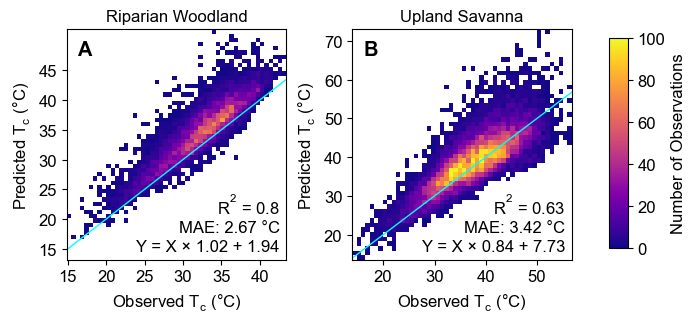

In [28]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

f, ax = plt.subplots(1, 2, sharex=False, sharey = False, figsize = (190 / constants.inch /1000, 190 / constants.inch /1000 * (0.4)))

ax1_plt_vals = CMW_Eddy_Covariance_daytime[['T_CANOPY_1_1_1', 'tc_pred']].dropna()
ax1_x = ax1_plt_vals.T_CANOPY_1_1_1
ax1_y = ax1_plt_vals.tc_pred

ax1_counts, ax1_xbins, ax1_ybins = np.histogram2d(ax1_x, ax1_y, bins=(50, 50))
ax1_counts[ax1_counts == 0] = np.nan

p1 = ax[0].pcolormesh(ax1_xbins, ax1_ybins, ax1_counts.T, cmap='plasma', snap = True)
ax[0].set_xlabel('Observed T$\mathregular{_{c}}$ (°C)')
ax[0].set_ylabel('Predicted T$\mathregular{_{c}}$ (°C)')
ax[0].set_xticks(np.arange(15, 46, 5))
ax[0].set_yticks(np.arange(15, 46, 5))
#ax[0].axline((15, 15 * CMW_bias_mod[1] + CMW_bias_mod[0]), slope=CMW_bias_mod[1], c='red', linewidth = 1)
ax[0].axline((15, 15), slope=1, c='cyan', linewidth = 1)
ax[0].set_title('Riparian Woodland')
ax[0].text(0.05, 0.89, "A", transform = ax[0].transAxes, fontsize = 'large', fontweight = 'bold')
ax[0].text(0.97, 0.2, "R$\mathregular{^{2}}$ = " + str(cmw_tc_pred_model.rsquared.round(2)), transform = ax[0].transAxes, horizontalalignment = 'right')
ax[0].text(0.97, 0.12, "MAE: " + str(np.mean(np.abs(CMW_Eddy_Covariance_daytime.T_CANOPY_1_1_1 - CMW_Eddy_Covariance_daytime.tc_pred)).round(2)) + " °C", transform = ax[0].transAxes, horizontalalignment = 'right')
ax[0].text(0.97, 0.04, "Y = X × " + str(cmw_tc_pred_model.params[1].round(2)) + " + " + str(cmw_tc_pred_model.params[0].round(2)), transform = ax[0].transAxes, horizontalalignment = 'right')

p1.set_clim(0, 100)

#Axis 2
ax2_plt_vals = SRM_Eddy_Covariance_daytime[['T_CANOPY_1_1_1', 'tc_pred']].dropna()
ax2_x = ax2_plt_vals.T_CANOPY_1_1_1
ax2_y = ax2_plt_vals.tc_pred

ax2_counts, ax2_xbins, ax2_ybins = np.histogram2d(ax2_x, ax2_y, bins=(50, 50))
ax2_counts[ax2_counts == 0] = np.nan

p2 = ax[1].pcolormesh(ax2_xbins, ax2_ybins, ax2_counts.T, cmap='plasma', snap = True)
ax[1].set_xlabel('Observed T$\mathregular{_{c}}$ (°C)')
ax[1].set_ylabel('Predicted T$\mathregular{_{c}}$ (°C)')
ax[1].set_xticks(np.arange(20, 71, 10))
ax[1].set_yticks(np.arange(20, 71, 10))
ax[1].axline((15, 15), slope=1, c='cyan', linewidth = 1)
#ax[1].axline((15, 15 * SRM_bias_mod[1] + SRM_bias_mod[0]), slope=SRM_bias_mod[1], c='red', linewidth = 1)
ax[1].set_title('Upland Savanna')
ax[1].text(0.05, 0.89, "B", transform = ax[1].transAxes, fontsize = 'large', fontweight = 'bold')
ax[1].text(0.97, 0.2, "R$\mathregular{^{2}}$ = " + str(srm_tc_pred_model.rsquared.round(2)), transform = ax[1].transAxes, horizontalalignment = 'right')
ax[1].text(0.97, 0.12, "MAE: " + str(np.mean(np.abs(SRM_Eddy_Covariance_daytime.T_CANOPY_1_1_1 - SRM_Eddy_Covariance_daytime.tc_pred)).round(2)) + " °C", transform = ax[1].transAxes, horizontalalignment = 'right')
ax[1].text(0.97, 0.04, "Y = X × " + str(srm_tc_pred_model.params[1].round(2)) + " + " + str(srm_tc_pred_model.params[0].round(2)), transform = ax[1].transAxes, horizontalalignment = 'right')

p2.set_clim(0, 100)

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.025, 0.7])
f.colorbar(p2, cax=cbar_ax, label = 'Number of Observations')

plt.subplots_adjust(wspace=0.3)

plt.show()

In [29]:
f.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\pred_obs_temp.pdf', bbox_inches = 'tight')

Double check that the plots are rendering correctly by comparing it to another plotting package:

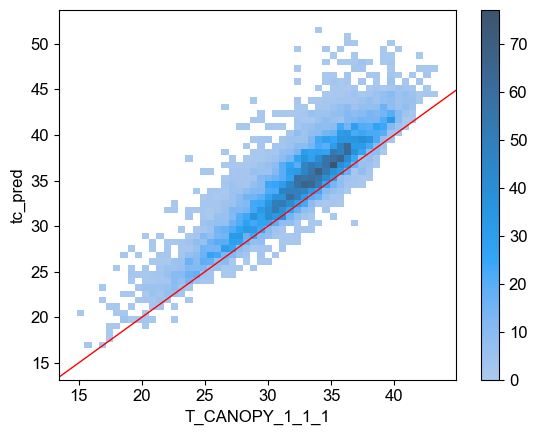

In [30]:
sns.histplot(CMW_Eddy_Covariance_daytime, x = 'T_CANOPY_1_1_1', y ='tc_pred', cbar = True, bins = 50)
plt.axline((15, 15), slope=1, c='red', linewidth = 1)

# Energy Balance Closure

## Assess Energy Balance Closure

### Charleston Mesquite Woodland

In [31]:
np.nanpercentile(CMW_Eddy_Covariance_daytime.Closure, [25, 50, 75]).round(2)

array([0.75, 0.86, 0.98])

### Santa Rita Mesquite

In [32]:
np.nanpercentile(SRM_Eddy_Covariance_daytime.Closure, [25, 50, 75]).round(2)

array([0.75, 0.83, 0.92])

### Plots

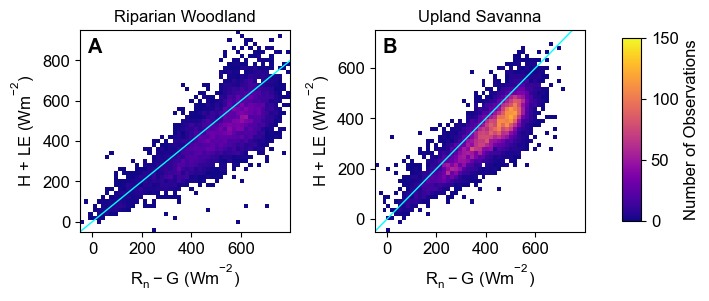

In [33]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

f, ax = plt.subplots(1, 2, sharex=True, sharey = False, figsize = (190 / constants.inch /1000, 190 / constants.inch /1000 * (0.35)))

ax1_plt_vals = CMW_Eddy_Covariance_daytime[['Rn_G', 'H', 'LE']].dropna()
ax1_x = ax1_plt_vals.Rn_G
ax1_y = ax1_plt_vals.H + ax1_plt_vals.LE

ax1_counts, ax1_xbins, ax1_ybins = np.histogram2d(ax1_x, ax1_y, bins=(50, 50), range = [[-50, 800], [-50, 950]])
ax1_counts[ax1_counts == 0] = np.nan

p1 = ax[0].pcolormesh(ax1_xbins, ax1_ybins, ax1_counts.T, cmap='plasma', snap = True)
ax[0].set_xlabel('$\mathregular{R_n - G}$ (Wm$\mathregular{^{-2}}$)')
ax[0].set_ylabel('H + LE (Wm$\mathregular{^{-2}}$)')
ax[0].set_title('Riparian Woodland')
ax[0].set_xticks(np.arange(0, 801, 200))
ax[0].set_xlim(-50, 800)
ax[0].text(0.04, 0.89, "A", transform = ax[0].transAxes, fontsize = 'large', fontweight = 'bold')
ax[0].axline((15, 15), slope=1, c='cyan', linewidth = 1)

p1.set_clim(0, 150)

#Axis 2
ax2_plt_vals = SRM_Eddy_Covariance_daytime[['Rn_G', 'H', 'LE']].dropna()
ax2_x = ax2_plt_vals.Rn_G
ax2_y = ax2_plt_vals.H + ax2_plt_vals.LE

ax2_counts, ax2_xbins, ax2_ybins = np.histogram2d(ax2_x, ax2_y, bins=(50, 50), range = [[-50, 750], [-50, 750]])
ax2_counts[ax2_counts == 0] = np.nan

p2 = ax[1].pcolormesh(ax2_xbins, ax2_ybins, ax2_counts.T, cmap='plasma', snap = True)
ax[1].set_xlabel('$\mathregular{R_n - G}$ (Wm$\mathregular{^{-2}}$)')
ax[1].set_ylabel('H + LE (Wm$\mathregular{^{-2}}$)')
ax[1].set_title('Upland Savanna')
ax[1].set_xticks(np.arange(0, 601, 200))
ax[1].text(0.04, 0.89, "B", transform = ax[1].transAxes, fontsize = 'large', fontweight = 'bold')
ax[1].axline((15, 15), slope=1, c='cyan', linewidth = 1)

p2.set_clim(0, 150)

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.025, 0.7])
f.colorbar(p2, cax=cbar_ax, label = 'Number of Observations')

plt.subplots_adjust(wspace=0.4)

plt.show()

In [34]:
f.figure.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\closure_hist.pdf', bbox_inches = 'tight')

Double check that the plot is rendering correctly by comparing to a different plotting package

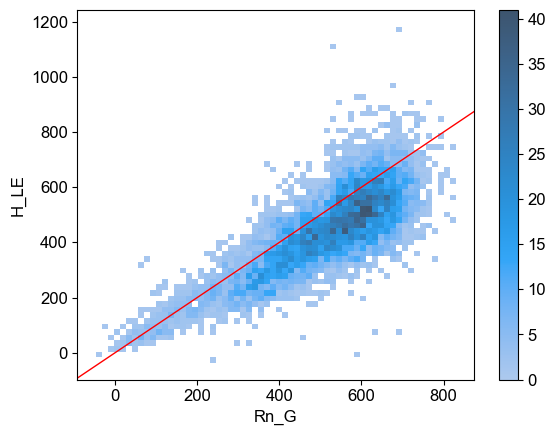

In [35]:
test = CMW_Eddy_Covariance_daytime[['Rn_G', 'H', 'LE']].dropna()
test['H_LE'] = test.H + test.LE

sns.histplot(test, x = 'Rn_G', y ='H_LE', cbar = True, bins = 60)
plt.axline((15, 15), slope=1, c='red', linewidth = 1)

## Force Energy Balance Closure by Preserving H+LE

### Charleston Mesquite Woodland

Force energy balance closure by preserving H+LE and adjusting Qa

In [36]:
CMW_forced_A = CMW_Eddy_Covariance_daytime.H + CMW_Eddy_Covariance_daytime.LE

CMW_Eddy_Covariance_daytime['forced_A_tc_pred'] = ((CMW_Eddy_Covariance_daytime.TA_1_2_1 + 273.15) + calc_tc_ta(rn = CMW_forced_A, 
                                                         le = CMW_Eddy_Covariance_daytime.LE, 
                                                         g = 0, #implicitly included in CMW_forced_A
                                                         rah = CMW_Eddy_Covariance_daytime.opt_rha, 
                                                         rho = CMW_Eddy_Covariance_daytime.rho, 
                                                         cp = CMW_Eddy_Covariance_daytime.cp)) - 273.15

Check that code is working properly by doing the calculations manually and comparing the results

In [37]:
lt = (CMW_Eddy_Covariance_daytime.LE + CMW_Eddy_Covariance_daytime.H) * CMW_Eddy_Covariance_daytime.opt_rha
lb = CMW_Eddy_Covariance_daytime.rho * CMW_Eddy_Covariance_daytime.cp
r = (1 - (CMW_Eddy_Covariance_daytime.LE/(CMW_Eddy_Covariance_daytime.LE + CMW_Eddy_Covariance_daytime.H)))
CMW_test = (((lt/lb) * r) + (CMW_Eddy_Covariance_daytime.TA_1_2_1 + 273.15)) - 273.15

CMW_test = CMW_test[np.logical_not(np.isnan(CMW_test))]
np.all(np.isclose(CMW_test, CMW_Eddy_Covariance_daytime.forced_A_tc_pred.dropna(), atol = 1e-9))

True

Calculate MAE and bias between unforced and forced TL values

In [38]:
np.mean(np.abs(CMW_Eddy_Covariance_daytime.tc_pred - CMW_Eddy_Covariance_daytime.forced_A_tc_pred)).round(2)

1.38

In [39]:
calcBias(CMW_Eddy_Covariance_daytime, pred_col = 'forced_A_tc_pred', obs_col = 'tc_pred').round(2)

-1.06

Calculate R2 and slope between unforced and forced TL values

In [40]:
smf.ols('forced_A_tc_pred ~ T_CANOPY_1_1_1', data = CMW_Eddy_Covariance_daytime).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       forced_A_tc_pred   R-squared:                       0.888
Model:                            OLS   Adj. R-squared:                  0.888
Method:                 Least Squares   F-statistic:                 5.842e+04
Date:                Thu, 16 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:21:11   Log-Likelihood:                -13977.
No. Observations:                7370   AIC:                         2.796e+04
Df Residuals:                    7368   BIC:                         2.797e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept         -0.1902      0.142     -1.340      0.180      -0.468       0.088
T_CANOPY_1_1_1     1.0515      0.004    241.708      0.000       1.043       1.060
==============================================================================
Omnibus:                     2280.895   Durbin-Watson:                   0.867
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            14928.135
Skew:                           1.320   Prob(JB):                         0.00
Kurtosis:                       9.453   Cond. No.                         247.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Santa Rita Mesquite

Force energy balance closure by preserving H+LE and adjusting Qa

In [41]:
SRM_forced_A = SRM_Eddy_Covariance_daytime.H + SRM_Eddy_Covariance_daytime.LE

SRM_Eddy_Covariance_daytime['forced_A_tc_pred'] = ((SRM_Eddy_Covariance_daytime.TA_1_2_1 + 273.15) + calc_tc_ta(rn = SRM_forced_A, 
                                                         le = SRM_Eddy_Covariance_daytime.LE, 
                                                         g = 0, #implicitly included in SRM_forced_A
                                                         rah = SRM_Eddy_Covariance_daytime.opt_rha, 
                                                         rho = SRM_Eddy_Covariance_daytime.rho, 
                                                         cp = SRM_Eddy_Covariance_daytime.cp)) - 273.15

Check that code is working properly by doing the calculations manually and comparing the results

In [42]:
lt = (SRM_Eddy_Covariance_daytime.LE + SRM_Eddy_Covariance_daytime.H) * SRM_Eddy_Covariance_daytime.opt_rha
lb = SRM_Eddy_Covariance_daytime.rho * SRM_Eddy_Covariance_daytime.cp
r = (1 - (SRM_Eddy_Covariance_daytime.LE/(SRM_Eddy_Covariance_daytime.LE + SRM_Eddy_Covariance_daytime.H)))
SRM_test = (((lt/lb) * r) + (SRM_Eddy_Covariance_daytime.TA_1_2_1 + 273.15)) - 273.15

SRM_test = SRM_test[np.logical_not(np.isnan(SRM_test))]
np.all(np.isclose(SRM_test, SRM_Eddy_Covariance_daytime.forced_A_tc_pred.dropna(), atol = 1e-9))

True

Calculate MAE and bias between unforced and forced TL values

In [43]:
np.mean(np.abs(SRM_Eddy_Covariance_daytime.tc_pred - SRM_Eddy_Covariance_daytime.forced_A_tc_pred)).round(2)

1.8

In [44]:
calcBias(SRM_Eddy_Covariance_daytime, pred_col = 'forced_A_tc_pred', obs_col = 'tc_pred').round(2)

-1.64

Calculate R2 and slope between unforced and forced TL values

In [45]:
smf.ols('forced_A_tc_pred ~ T_CANOPY_1_1_1', data = SRM_Eddy_Covariance_daytime).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:       forced_A_tc_pred   R-squared:                       0.701
Model:                            OLS   Adj. R-squared:                  0.701
Method:                 Least Squares   F-statistic:                 3.337e+04
Date:                Thu, 16 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:21:19   Log-Likelihood:                -37679.
No. Observations:               14224   AIC:                         7.536e+04
Df Residuals:                   14222   BIC:                         7.538e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          6.8376      0.172     39.711      0.000       6.500       7.175
T_CANOPY_1_1_1     0.8174      0.004    182.679      0.000       0.809       0.826
==============================================================================
Omnibus:                     1603.369   Durbin-Watson:                   0.720
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3501.661
Skew:                           0.696   Prob(JB):                         0.00
Kurtosis:                       4.993   Cond. No.                         231.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Plot Closure vs. Prediction Error

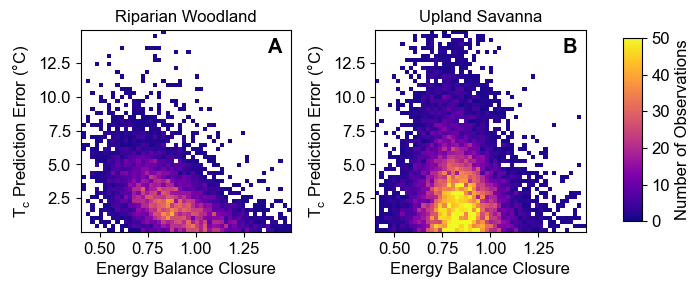

In [46]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

f, ax = plt.subplots(1, 2, sharex=True, sharey = False, figsize = (190 / constants.inch /1000, 190 / constants.inch /1000 * (0.35)))

ax1_plt_vals = CMW_Eddy_Covariance_daytime[['T_CANOPY_1_1_1', 'tc_pred', 'Closure']].dropna()
ax1_plt_vals['error'] = np.abs(ax1_plt_vals.tc_pred - ax1_plt_vals.T_CANOPY_1_1_1)
ax1_plt_vals = ax1_plt_vals[(ax1_plt_vals.Closure > 0.4) & (ax1_plt_vals.Closure < 1.5) & (ax1_plt_vals.error < 15)]
ax1_x = ax1_plt_vals.Closure
ax1_y = ax1_plt_vals.error

ax1_counts, ax1_xbins, ax1_ybins = np.histogram2d(ax1_x, ax1_y, bins=(50, 50))
ax1_counts[ax1_counts == 0] = np.nan

p1 = ax[0].pcolormesh(ax1_xbins, ax1_ybins, ax1_counts.T, cmap='plasma', snap = True)
ax[0].set_xlabel('Energy Balance Closure')
ax[0].set_ylabel('T$\mathregular{_{c}}$ Prediction Error (°C)')
ax[0].set_title('Riparian Woodland')
ax[0].set_xticks(np.arange(0.5, 1.3, 0.25))
ax[0].text(0.89, 0.89, "A", transform = ax[0].transAxes, fontsize = 'large', fontweight = 'bold')

p1.set_clim(0, 50)

#Axis 2
ax2_plt_vals = SRM_Eddy_Covariance_daytime[['T_CANOPY_1_1_1', 'tc_pred', 'Closure']].dropna()
ax2_plt_vals['error'] = np.abs(ax2_plt_vals.tc_pred - ax2_plt_vals.T_CANOPY_1_1_1)
ax2_plt_vals = ax2_plt_vals[(ax2_plt_vals.Closure > 0.4) & (ax2_plt_vals.Closure < 1.5) & (ax2_plt_vals.error < 15)]
ax2_x = ax2_plt_vals.Closure
ax2_y = ax2_plt_vals.error

ax2_counts, ax2_xbins, ax2_ybins = np.histogram2d(ax2_x, ax2_y, bins=(50, 50))
ax2_counts[ax2_counts == 0] = np.nan

p2 = ax[1].pcolormesh(ax2_xbins, ax2_ybins, ax2_counts.T, cmap='plasma', snap = True)
ax[1].set_xlabel('Energy Balance Closure')
ax[1].set_ylabel('T$\mathregular{_{c}}$ Prediction Error (°C)')
ax[1].set_title('Upland Savanna')
ax[1].set_xticks(np.arange(0.5, 1.3, 0.25))
ax[1].text(0.89, 0.89, "B", transform = ax[1].transAxes, fontsize = 'large', fontweight = 'bold')

p2.set_clim(0, 50)

f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.025, 0.7])
f.colorbar(p2, cax=cbar_ax, label = 'Number of Observations')

plt.subplots_adjust(wspace=0.4)

plt.show()

In [47]:
f.figure.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\closure_vs_error.pdf', bbox_inches = 'tight')

Same plot but with a different package to confirm output

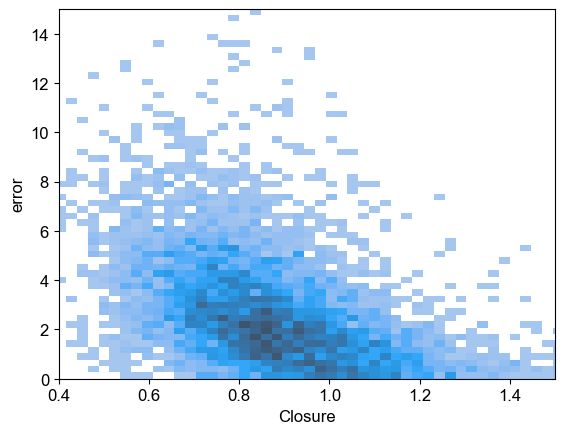

In [48]:
closure_plot = CMW_Eddy_Covariance_daytime.copy()
closure_plot['error'] = np.abs(closure_plot.tc_pred - closure_plot.T_CANOPY_1_1_1)
sns.histplot(closure_plot, x = 'Closure', y = 'error')
plt.xlim(0.4, 1.5)
plt.ylim(0,15)
plt.show()

Scatterplot to confirm output

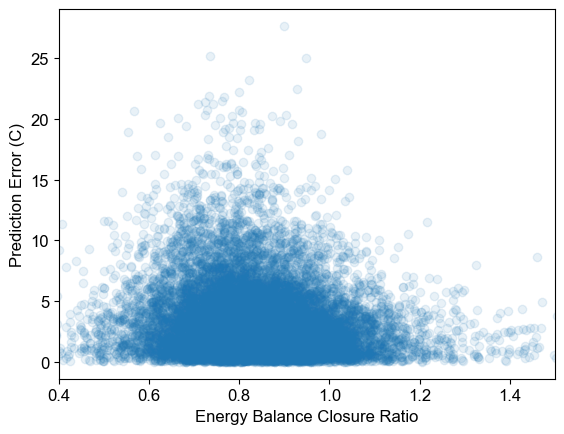

In [49]:
plt.scatter(SRM_Eddy_Covariance_daytime.Closure, np.abs(SRM_Eddy_Covariance_daytime.tc_pred - SRM_Eddy_Covariance_daytime.T_CANOPY_1_1_1), alpha = 0.1)
plt.xlim(0.4, 1.5)
plt.xlabel('Energy Balance Closure Ratio')
plt.ylabel('Prediction Error (C)')
plt.show()

# Relationship between Tc and Ta

## Summary Statistics

Charleston Mesquite Woodland

In [50]:
smf.ols('T_CANOPY_1_1_1 ~ TA_1_2_1', data = CMW_Eddy_Covariance_daytime).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         T_CANOPY_1_1_1   R-squared:                       0.850
Model:                            OLS   Adj. R-squared:                  0.849
Method:                 Least Squares   F-statistic:                 4.160e+04
Date:                Thu, 16 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:21:33   Log-Likelihood:                -14260.
No. Observations:                7371   AIC:                         2.852e+04
Df Residuals:                    7369   BIC:                         2.854e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.1774      0.139     29.960      0.000       3.904       4.451
TA_1_2_1       0.9152      0.004    203.953      0.000       0.906       0.924
==============================================================================
Omnibus:                     1446.305   Durbin-Watson:                   0.156
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3208.169
Skew:                           1.127   Prob(JB):                         0.00
Kurtosis:                       5.315   Cond. No.                         222.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Santa Rita Mesquite

In [51]:
smf.ols('T_CANOPY_1_1_1 ~ TA_1_2_1', data = SRM_Eddy_Covariance_daytime).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:         T_CANOPY_1_1_1   R-squared:                       0.675
Model:                            OLS   Adj. R-squared:                  0.675
Method:                 Least Squares   F-statistic:                 2.959e+04
Date:                Thu, 16 Mar 2023   Prob (F-statistic):               0.00
Time:                        16:21:37   Log-Likelihood:                -38610.
No. Observations:               14224   AIC:                         7.722e+04
Df Residuals:                   14222   BIC:                         7.724e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.1695      0.216      5.416      0.000       0.746       1.593
TA_1_2_1       1.1679      0.007    172.026      0.000       1.155       1.181
==============================================================================
Omnibus:                      524.439   Durbin-Watson:                   0.165
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              574.182
Skew:                           0.483   Prob(JB):                    2.08e-125
Kurtosis:                       2.812   Cond. No.                         224.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Mean TL-TA values across the entire time series:

In [52]:
CMW_Eddy_Covariance_daytime.IR_tc_ta.mean().round(2)

1.57

In [53]:
SRM_Eddy_Covariance_daytime.IR_tc_ta.mean().round(2)

6.46

Maximum (99th percentile) TC-TA values across the entire time series

In [54]:
np.percentile(CMW_Eddy_Covariance_daytime.IR_tc_ta, 99).round(2)

7.61

In [55]:
np.percentile(SRM_Eddy_Covariance_daytime.IR_tc_ta, 99).round(2)

16.44

Minimum (1st percentile) TC-TA values across the entire time series

In [56]:
np.percentile(CMW_Eddy_Covariance_daytime.IR_tc_ta, 1).round(2)

-1.24

In [57]:
np.percentile(SRM_Eddy_Covariance_daytime.IR_tc_ta, 1).round(2)

-0.25

Mean evaporative fraction across the entire time series:

In [58]:
CMW_Eddy_Covariance_daytime.Evap_Frac.mean().round(2)

0.46

In [59]:
SRM_Eddy_Covariance_daytime.Evap_Frac.mean().round(2)

0.15

## Plot TL and TL-TA

https://stackoverflow.com/questions/64767788/compute-mean-value-per-pixel-using-weighted-2d-histogram

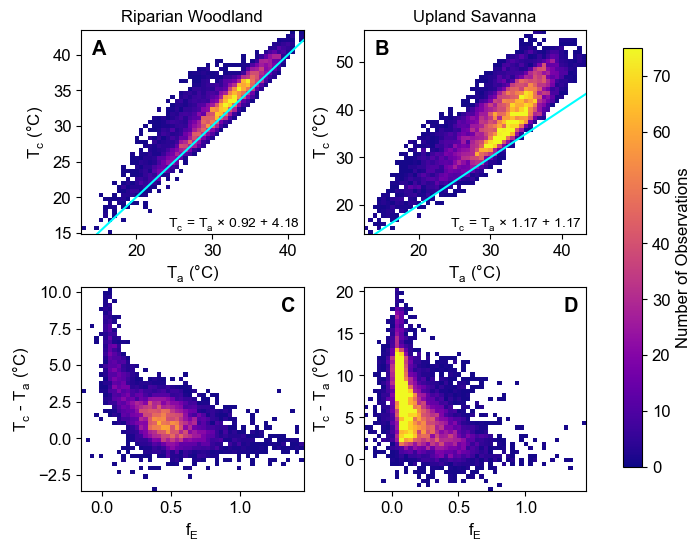

In [60]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

fig, ax = plt.subplots(2, 2, figsize = (7.48031, 7.48031 * 0.8))

#Axis 1
ax1_plt_vals = CMW_Eddy_Covariance_daytime[['T_CANOPY_1_1_1', 'TA_1_2_1']].dropna()
ax1_x = ax1_plt_vals.TA_1_2_1
ax1_y = ax1_plt_vals.T_CANOPY_1_1_1

ax1_counts, ax1_xbins, ax1_ybins = np.histogram2d(ax1_x, ax1_y, bins=(50, 50))
ax1_counts[ax1_counts == 0] = np.nan

p1 = ax[0,0].pcolormesh(ax1_xbins, ax1_ybins, ax1_counts.T, cmap='plasma', snap = True)
ax[0,0].set_xlabel('T$\mathregular{_{a}}$ (°C)', labelpad = 2)
ax[0,0].set_ylabel('T$\mathregular{_{c}}$ (°C)')
ax[0,0].axline((15, 15), slope=1, c='cyan', linewidth = 1.5)
ax[0,0].set_title('Riparian Woodland')
ax[0,0].text(0.05, 0.88, "A", transform = ax[0,0].transAxes, fontsize = 'large', fontweight = 'bold')
ax[0,0].text(0.39, 0.03, "T$\mathregular{_{c}}$ = T$\mathregular{_{a}}$ × 0.92 + 4.18", transform = ax[0,0].transAxes, fontsize = 'small')
p1.set_clim(0, 75)

#Axis 2
ax2_plt_vals = SRM_Eddy_Covariance_daytime[['T_CANOPY_1_1_1', 'TA_1_2_1']].dropna()
ax2_x = ax2_plt_vals.TA_1_2_1
ax2_y = ax2_plt_vals.T_CANOPY_1_1_1

ax2_counts, ax2_xbins, ax2_ybins = np.histogram2d(ax2_x, ax2_y, bins=(50, 50))
ax2_counts[ax2_counts == 0] = np.nan

p2 = ax[0,1].pcolormesh(ax2_xbins, ax2_ybins, ax2_counts.T, cmap='plasma', snap = True)
ax[0,1].set_xlabel('T$\mathregular{_{a}}$ (°C)', labelpad = 2)
ax[0,1].set_ylabel('T$\mathregular{_{c}}$ (°C)', labelpad = 2)
ax[0,1].axline((15, 15), slope=1, c='cyan', linewidth = 1.5)
ax[0,1].set_title('Upland Savanna')
ax[0,1].text(0.05, 0.88, "B", transform = ax[0,1].transAxes, fontsize = 'large', fontweight = 'bold')
ax[0,1].text(0.39, 0.03, "T$\mathregular{_{c}}$ = T$\mathregular{_{a}}$ × 1.17 + 1.17", transform = ax[0,1].transAxes, fontsize = 'small')
p2.set_clim(0, 75)

#Axis 3
ax3_plt_vals = CMW_Eddy_Covariance_daytime[['Evap_Frac', 'IR_tc_ta']].dropna()
ax3_plt_vals = ax3_plt_vals[(ax3_plt_vals.Evap_Frac < 1.5) & (ax3_plt_vals.Evap_Frac > -0.25)]
ax3_x = ax3_plt_vals.Evap_Frac
ax3_y = ax3_plt_vals.IR_tc_ta

ax3_counts, ax3_xbins, ax3_ybins = np.histogram2d(ax3_x, ax3_y, bins=(50, 50))
ax3_counts[ax3_counts == 0] = np.nan

p3 = ax[1,0].pcolormesh(ax3_xbins, ax3_ybins, ax3_counts.T, cmap='plasma', snap = True)
ax[1,0].set_xlabel('$\mathregular{f_{E}}$')
ax[1,0].set_ylabel('T$\mathregular{_{c}}$ - T$\mathregular{_{a}}$ (°C)')
ax[1,0].text(0.9, 0.88, "C", transform = ax[1,0].transAxes, fontsize = 'large', fontweight = 'bold')
p3.set_clim(0, 75)

#Axis 4
ax4_plt_vals = SRM_Eddy_Covariance_daytime[['Evap_Frac', 'IR_tc_ta']].dropna()
ax4_plt_vals = ax4_plt_vals[(ax4_plt_vals.Evap_Frac < 1.5) & (ax4_plt_vals.Evap_Frac > -0.25)]
ax4_x = ax4_plt_vals.Evap_Frac
ax4_y = ax4_plt_vals.IR_tc_ta

ax4_counts, ax4_xbins, ax4_ybins = np.histogram2d(ax4_x, ax4_y, bins=(50, 50))
ax4_counts[ax4_counts == 0] = np.nan

p4 = ax[1,1].pcolormesh(ax4_xbins, ax4_ybins, ax4_counts.T, cmap='plasma', snap = True)
ax[1,1].set_xlabel('$\mathregular{f_{E}}$')
ax[1,1].set_ylabel('T$\mathregular{_{c}}$ - T$\mathregular{_{a}}$ (°C)', labelpad = 2)
ax[1,1].text(0.9, 0.88, "D", transform = ax[1,1].transAxes, fontsize = 'large', fontweight = 'bold')
p4.set_clim(0, 75)

fig.subplots_adjust(right=0.8, wspace = 0.27, hspace = 0.26)
cbar_ax = fig.add_axes([0.85, 0.15, 0.025, 0.7])
fig.colorbar(p4, cax=cbar_ax, label = 'Number of Observations')

plt.show()

In [61]:
fig.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\heatmap.pdf', bbox_inches = 'tight')

# Climatology

## Diurnal Trends

### Calculate diurnal climatologies

In [62]:
CMW_diurnal = CMW_Eddy_Covariance_daytime.copy()[['month', 'time', 'IR_tc_ta', 'T_CANOPY_1_1_1', 'Evap_Frac', 'opt_rha', 'TA_1_2_1', 'Rn_G']]
CMW_diurnal = CMW_diurnal.groupby(['month', 'time']).mean().reset_index()

SRM_diurnal = SRM_Eddy_Covariance_daytime.copy()[['month', 'time', 'IR_tc_ta', 'T_CANOPY_1_1_1', 'Evap_Frac', 'opt_rha',  'TA_1_2_1', 'Rn_G']]
SRM_diurnal = SRM_diurnal[SRM_diurnal.Evap_Frac > -5] #drop 3 outliers with crazy fE values
SRM_diurnal = SRM_diurnal.groupby(['month', 'time']).mean().reset_index()

Peak daily TL-TA values for each month:

In [63]:
CMW_diurnal[CMW_diurnal.month == 5].max()['IR_tc_ta'].round(2)

4.27

In [64]:
CMW_diurnal[CMW_diurnal.month == 6].max()['IR_tc_ta'].round(2)

2.44

In [65]:
SRM_diurnal[SRM_diurnal.month == 6].max()['IR_tc_ta'].round(2)

10.59

In [66]:
SRM_diurnal[SRM_diurnal.month == 8].max()['IR_tc_ta'].round(2)

5.72

### Plot Results

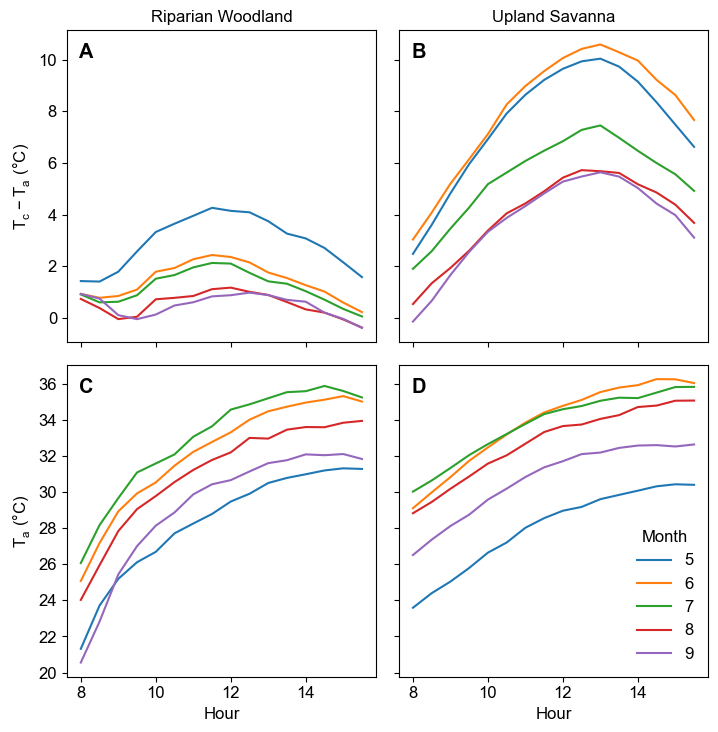

In [67]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

f, axs = plt.subplots(2, 2, sharex=True, sharey = 'row', figsize = (190 / constants.inch /1000, 190 / constants.inch /1000))
sns.lineplot(x = 'time', y = 'IR_tc_ta', hue = 'month', data = CMW_diurnal, palette = "tab10", ax=axs[0,0])
axs[0,0].set(ylabel = '$\mathregular{T_c - T_a}$ (°C)', title = 'Riparian Woodland')
axs[0,0].legend_.remove()
axs[0,0].text(0.04, 0.91, "A", transform = axs[0,0].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'IR_tc_ta', hue = 'month', data = SRM_diurnal, palette = "tab10", ax=axs[0,1])
axs[0,1].set(title = 'Upland Savanna')
axs[0,1].legend_.remove()
axs[0,1].set_xticks(np.arange(8, 16, 2))
axs[0,1].text(0.04, 0.91, "B", transform = axs[0,1].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'TA_1_2_1', hue = 'month', data = CMW_diurnal, palette = "tab10", ax=axs[1,0])
axs[1,0].set(ylabel = '$\mathregular{T_a}$ (°C)', xlabel = 'Hour')
axs[1,0].legend_.remove()
axs[1,0].text(0.04, 0.91, "C", transform = axs[1,0].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'TA_1_2_1', hue = 'month', data = SRM_diurnal, palette = "tab10", ax=axs[1,1])
axs[1,1].set(xlabel = 'Hour')
axs[1,1].legend(title = 'Month', frameon = False)
axs[1,1].text(0.04, 0.91, "D", transform = axs[1,1].transAxes, fontsize = 'large', fontweight = 'bold')

f.tight_layout()

In [68]:
f.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\diurnal_tc_ta.pdf', bbox_inches = 'tight')

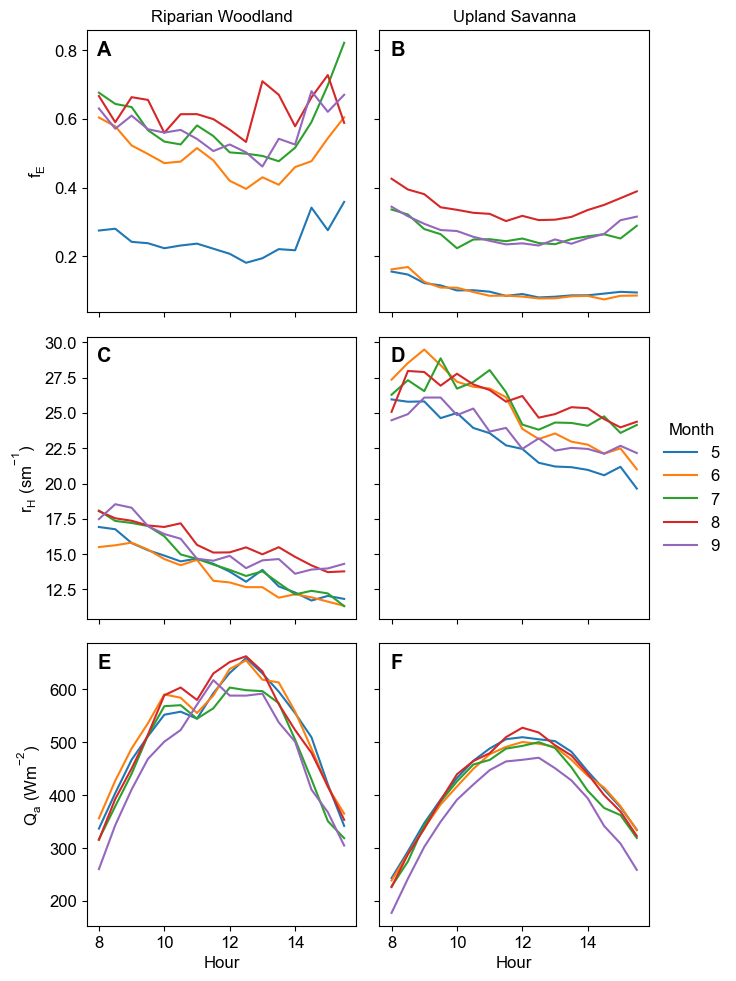

In [69]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

f, axs = plt.subplots(3, 2, sharex=True, sharey = 'row', figsize = (190 / constants.inch /1000, 190 / constants.inch /1000 * (4/3)))
sns.lineplot(x = 'time', y = 'Evap_Frac', hue = 'month', data = CMW_diurnal, palette = "tab10", ax=axs[0,0])
axs[0,0].set(ylabel = '$\mathregular{f_E}$', title = 'Riparian Woodland')
axs[0,0].legend_.remove()
axs[0,0].text(0.04, 0.91, "A", transform = axs[0,0].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'Evap_Frac', hue = 'month', data = SRM_diurnal, palette = "tab10", ax=axs[0,1])
axs[0,1].set(title = 'Upland Savanna')
axs[0,1].legend_.remove()
axs[0,1].set_xticks(np.arange(8, 16, 2))
axs[0,1].text(0.04, 0.91, "B", transform = axs[0,1].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'opt_rha', hue = 'month', data = CMW_diurnal, palette = "tab10", ax=axs[1,0])
axs[1,0].set(ylabel = '$\mathregular{r_H}$ (s$\mathregular{m^{-1}}$)', xlabel = 'Hour')
axs[1,0].legend_.remove()
axs[1,0].text(0.04, 0.91, "C", transform = axs[1,0].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'opt_rha', hue = 'month', data = SRM_diurnal, palette = "tab10", ax=axs[1,1])
axs[1,1].set(xlabel = 'Hour')
axs[1,1].legend_.remove()
axs[1,1].text(0.04, 0.91, "D", transform = axs[1,1].transAxes, fontsize = 'large', fontweight = 'bold')
axs[1,1].legend(title = 'Month', bbox_to_anchor=(1, 0.75), frameon = False)

sns.lineplot(x = 'time', y = 'Rn_G', hue = 'month', data = CMW_diurnal, palette = "tab10", ax=axs[2,0])
axs[2,0].set(ylabel = '$\mathregular{Q_a}$ ($\mathregular{Wm^{-2}}$)', xlabel = 'Hour')
axs[2,0].legend_.remove()
axs[2,0].text(0.04, 0.91, "E", transform = axs[2,0].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'Rn_G', hue = 'month', data = SRM_diurnal, palette = "tab10", ax=axs[2,1])
axs[2,1].set(xlabel = 'Hour')
axs[2,1].text(0.04, 0.91, "F", transform = axs[2,1].transAxes, fontsize = 'large', fontweight = 'bold')
axs[2,1].legend_.remove()

f.tight_layout()

In [70]:
f.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\diurnal_drivers.pdf', bbox_inches = 'tight')

# Calculate Resistance Directly from Temperature

## Calculate Seasonal Climatologies

In [71]:
#Select variables needed for calculation
CMW_rha_temp = CMW_Eddy_Covariance_daytime.copy()[['TA_1_2_1', 'IR_tc_ta','H', 'PA', 'RH_1_2_1', 'Evap_Frac', 'Rn_G', 'month', 'time']].dropna()

#Calculate resistance directly from temperature
CMW_rha_temp['rha_from_temp'] = calc_rha_from_temp(pa = CMW_rha_temp.PA, ta = CMW_rha_temp.TA_1_2_1, tc_ta = CMW_rha_temp.IR_tc_ta, h = CMW_rha_temp.H, rh = CMW_rha_temp.RH_1_2_1)

#Calculate monthly median value
CMW_rha_temp_summ = CMW_rha_temp.groupby('month').median().reset_index()
CMW_rha_temp_summ['site'] = 'CMW'

#Select variables needed for calculation
SRM_rha_temp = SRM_Eddy_Covariance_daytime.copy()[['TA_1_2_1', 'IR_tc_ta','H', 'PA', 'RH_1_2_1', 'Evap_Frac', 'Rn_G', 'month', 'time']].dropna()

#Calculate resistance directly from temperature
SRM_rha_temp['rha_from_temp'] = calc_rha_from_temp(pa = SRM_rha_temp.PA, ta = SRM_rha_temp.TA_1_2_1, tc_ta = SRM_rha_temp.IR_tc_ta, h = SRM_rha_temp.H, rh = SRM_rha_temp.RH_1_2_1)

#Calculate monthly median value
SRM_rha_temp_summ = SRM_rha_temp.groupby('month').median().reset_index()
SRM_rha_temp_summ['site'] = 'SRM'

#Concatenate data from both sites
rha_temp_summ = pd.concat([CMW_rha_temp_summ, SRM_rha_temp_summ])

## Plot Results

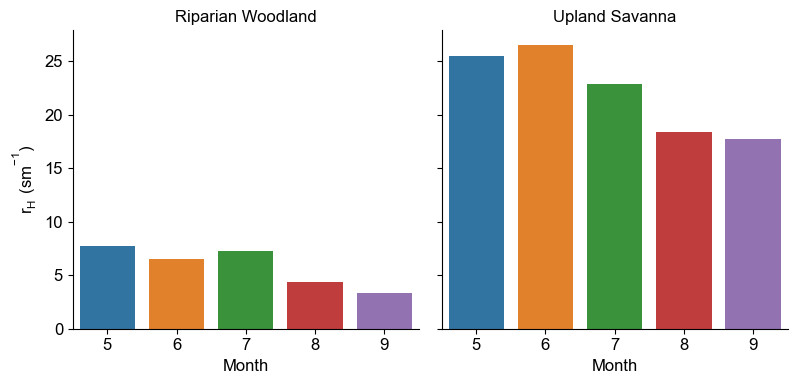

In [72]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

p = sns.catplot(data = rha_temp_summ, x = 'month', y = 'rha_from_temp', kind = 'bar', col = 'site', height = 4, aspect = 1)
p.set(xlabel = "Month", ylabel = "$\mathregular{r_{H}\ (sm^{-1})}$")
axes = p.axes.flatten()
axes[0].set_title("Riparian Woodland")
axes[1].set_title("Upland Savanna")
plt.show()

In [73]:
p.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\true_rh.pdf')

# Seasonal Trends

## Calculate Seasonal Climatologies

In [74]:
#Select variables for correlation analysis
CMW_corr_vals = CMW_Eddy_Covariance_daytime.copy()[['T_CANOPY_1_1_1', 'TA_1_2_1', 'IR_tc_ta', 'Rn_G', 'Evap_Frac', 'opt_rha', 'day', 'month', 'year', 'time']].dropna()

#Calculate monthly median values and join correlation variables
CMW_climate_summ = CMW_corr_vals[['Evap_Frac', 'opt_rha', 'month']].groupby(['month']).median().reset_index()

CMW_climate_summ.round(2)

,month,Evap_Frac,opt_rha
0,5,0.20,12.48
1,6,0.46,12.08
2,7,0.53,13.21
3,8,0.57,14.59
4,9,0.52,14.17


In [75]:
CMW_corr_vals[CMW_corr_vals.time == 12].groupby('month').Rn_G.mean().round(0)

month
5    631.0
6    639.0
7    604.0
8    652.0
9    588.0
Name: Rn_G, dtype: float64

In [76]:
#Select variables for correlation analysis
SRM_corr_vals = SRM_Eddy_Covariance_daytime.copy()[['T_CANOPY_1_1_1', 'TA_1_2_1', 'IR_tc_ta', 'Rn_G', 'Evap_Frac', 'opt_rha', 'day', 'month', 'year', 'time']].dropna()

#Calculate monthly median values and join correlation variables
SRM_climate_summ = SRM_corr_vals[['Evap_Frac', 'opt_rha', 'month']].groupby(['month']).median().reset_index()

SRM_climate_summ.round(2)

,month,Evap_Frac,opt_rha
0,5,0.08,20.35
1,6,0.07,23.02
2,7,0.23,24.34
3,8,0.32,24.56
4,9,0.24,22.32


In [77]:
SRM_corr_vals[SRM_corr_vals.time == 12].groupby('month').Rn_G.mean().round(0)

month
5    510.0
6    501.0
7    493.0
8    528.0
9    467.0
Name: Rn_G, dtype: float64

## Median Albedo

In [78]:
(np.nanmedian((CMW_Eddy_Covariance_daytime.SW_OUT/CMW_Eddy_Covariance_daytime.SW_IN)) * 100).round(1)

9.3

In [79]:
(np.nanmedian((SRM_Eddy_Covariance_daytime.SW_OUT/SRM_Eddy_Covariance_daytime.SW_IN)) * 100).round(1)

15.2

## Median Ground Heat Flux

In [80]:
np.median(CMW_Eddy_Covariance_daytime.G).round(0)

59.0

In [81]:
np.median(SRM_Eddy_Covariance_daytime.G).round(0)

119.0

## Plot Results

In [82]:
CMW_bar_vals = CMW_Eddy_Covariance_daytime.copy()[['Evap_Frac', 'opt_rha', 'Rn_G', 'year', 'month', 'day', 'time']].dropna()
CMW_bar_vals['site'] = 'CMW'
CMW_bar_vals.loc[CMW_bar_vals['time']!=12,['Rn_G']] = np.nan

SRM_bar_vals = SRM_Eddy_Covariance_daytime.copy()[['Evap_Frac', 'opt_rha', 'Rn_G', 'year', 'month', 'day', 'time']].dropna()
SRM_bar_vals['site'] = 'SRM'
SRM_bar_vals.loc[SRM_bar_vals['time']!=12,['Rn_G']] = np.nan

all_bar_vals = pd.concat([CMW_bar_vals, SRM_bar_vals])[['Evap_Frac', 'opt_rha', 'Rn_G', 'site', 'month']].melt(id_vars = ['site', 'month']).reset_index()

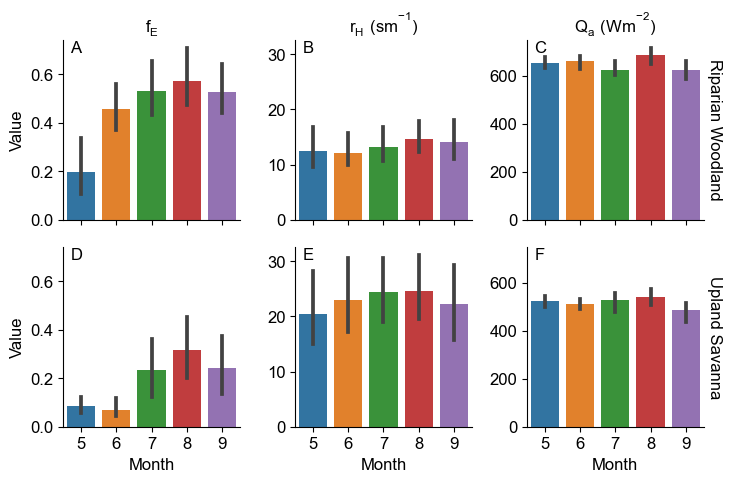

In [83]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

p = sns.catplot(x = "month", y = "value", col = "variable", row = 'site', data = all_bar_vals, kind = "bar", estimator = "median", errorbar = ("pi", 50), sharey = 'col', margin_titles = True, height = 7.48031/3, aspect = 1)
p.set(xlabel = "Month")
axes = p.axes.flatten()
axes[0].set_title("$\mathregular{f_{E}}$")
axes[0].text(0.04, 0.93, "A", transform = axes[0].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[0].set_ylabel("Value")
axes[1].set_title("$\mathregular{r_{H}\ (sm^{-1})}$")
axes[1].text(0.04, 0.93, "B", transform = axes[1].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[2].set_title("$\mathregular{Q_a\ (W m^{-2})}$")
axes[2].text(0.04, 0.93, "C", transform = axes[2].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[3].set_title(None)
axes[3].text(0.04, 0.93, "D", transform = axes[3].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[3].set_ylabel("Value")
axes[4].set_title(None)
axes[4].text(0.04, 0.93, "E", transform = axes[4].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[5].set_title(None)
axes[5].text(0.04, 0.93, "F", transform = axes[5].transAxes, fontsize = 'medium', fontweight = 'normal')

label_dict = {'CMW':'Riparian Woodland', 'SRM': 'Upland Savanna'}

for margin_title in p._margin_titles_texts:
    margin_title.set_text(label_dict[margin_title.get_text()[7:]])

plt.tight_layout()
plt.show()

In [84]:
p.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\climatology.pdf')

# Drivers of Leaf Temperature 

## Correlations with Air Temperature

Calculate correlations between TL and drivers:

In [85]:
#Extract correlations for leaf temperature by month from correlation matrix
CMW_corr_summ_TL = CMW_corr_vals.groupby(['month']).corr(method = 'spearman').reset_index().query('level_1 == "T_CANOPY_1_1_1"')[['TA_1_2_1', 'Evap_Frac', 'opt_rha', 'Rn_G', 'month']].melt(id_vars = ['month'])
CMW_corr_summ_TL['site'] = 'CMW'

#Extract correlations for leaf temperature by month from correlation matrix
SRM_corr_summ_TL = SRM_corr_vals.groupby(['month']).corr(method = 'spearman').reset_index().query('level_1 == "T_CANOPY_1_1_1"')[['TA_1_2_1', 'Evap_Frac', 'opt_rha', 'Rn_G', 'month']].melt(id_vars = ['month'])
SRM_corr_summ_TL['site'] = 'SRM'

#Concatenate data from both sites
corr_summ_TL = pd.concat([CMW_corr_summ_TL, SRM_corr_summ_TL])

In [86]:
corr_summ_TL

,month,variable,value,site
0,5,TA_1_2_1,0.852616,CMW
1,6,TA_1_2_1,0.958964,CMW
2,7,TA_1_2_1,0.966296,CMW
3,8,TA_1_2_1,0.965423,CMW
4,9,TA_1_2_1,0.967981,CMW
5,5,Evap_Frac,-0.149337,CMW
6,6,Evap_Frac,-0.347069,CMW
7,7,Evap_Frac,-0.449777,CMW
8,8,Evap_Frac,-0.343767,CMW
9,9,Evap_Frac,-0.228583,CMW


Correlation between TL and drivers by site and month:

In [87]:
corr_summ_TL[corr_summ_TL.variable == 'TA_1_2_1'].round(2).sort_values(by = ['site', 'month'])

,month,variable,value,site
0,5,TA_1_2_1,0.85,CMW
1,6,TA_1_2_1,0.96,CMW
2,7,TA_1_2_1,0.97,CMW
3,8,TA_1_2_1,0.97,CMW
4,9,TA_1_2_1,0.97,CMW
0,5,TA_1_2_1,0.84,SRM
1,6,TA_1_2_1,0.75,SRM
2,7,TA_1_2_1,0.86,SRM
3,8,TA_1_2_1,0.88,SRM
4,9,TA_1_2_1,0.83,SRM


Plot Results:

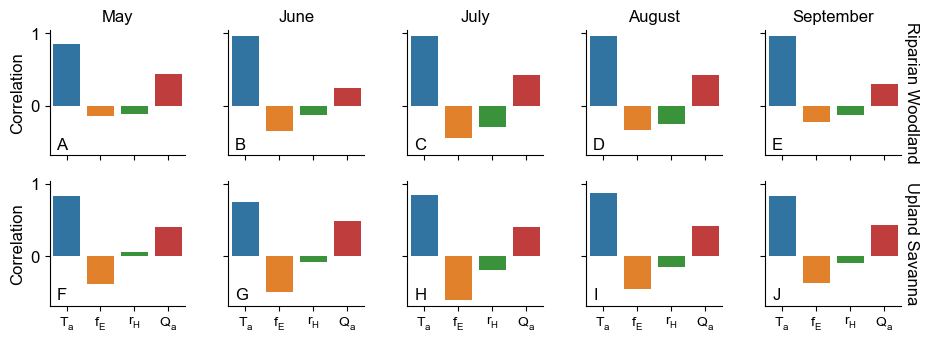

In [88]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

p = sns.catplot(x = "variable", y = "value", col = "month", row = 'site', data = corr_summ_TL, kind = "bar", margin_titles = True, height = 9.44882/5, aspect = 1)
p.set(xlabel = None, ylabel = "Correlation", xticklabels = ['$\mathregular{T_a}$', '$\mathregular{f_{E}}$', '$\mathregular{r_{H}}$', '$\mathregular{Q_a}$'])
axes = p.axes.flatten()
axes[0].set_title("May")
axes[1].set_title("June")
axes[2].set_title("July")
axes[3].set_title("August")
axes[4].set_title("September")
axes[5].set_title(None)
axes[6].set_title(None)
axes[7].set_title(None)
axes[8].set_title(None)

axes[0].text(0.05, 0.05, "A", transform = axes[0].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[1].text(0.05, 0.05, "B", transform = axes[1].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[2].text(0.05, 0.05, "C", transform = axes[2].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[3].text(0.05, 0.05, "D", transform = axes[3].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[4].text(0.05, 0.05, "E", transform = axes[4].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[5].text(0.05, 0.05, "F", transform = axes[5].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[6].text(0.05, 0.05, "G", transform = axes[6].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[7].text(0.05, 0.05, "H", transform = axes[7].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[8].text(0.05, 0.05, "I", transform = axes[8].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[9].text(0.05, 0.05, "J", transform = axes[9].transAxes, fontsize = 'medium', fontweight = 'normal')

for ax in axes.flat:
    ax.tick_params(axis='x', labelsize = 10)

label_dict = {'CMW':'Riparian Woodland', 'SRM': 'Upland Savanna'}

for margin_title in p._margin_titles_texts:
    margin_title.set_text(label_dict[margin_title.get_text()[7:]])

plt.show()

In [89]:
p.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\tc_drivers.pdf')

## Correlations Without Air Temperature

Calculate correlations between TL-TA and drivers by site and month:

In [90]:
CMW_corr_summ_TL_TA = CMW_corr_vals.groupby(['month']).corr(method = 'spearman').reset_index().query('level_1 == "IR_tc_ta"')[['Evap_Frac', 'opt_rha', 'Rn_G', 'month']].melt(id_vars = ['month'])
CMW_corr_summ_TL_TA['site'] = 'CMW'

SRM_corr_summ_TL_TA = SRM_corr_vals.groupby(['month']).corr(method = 'spearman').reset_index().query('level_1 == "IR_tc_ta"')[['Evap_Frac', 'opt_rha', 'Rn_G', 'month']].melt(id_vars = ['month'])
SRM_corr_summ_TL_TA['site'] = 'SRM'

corr_summ_TL_TA = pd.concat([CMW_corr_summ_TL_TA, SRM_corr_summ_TL_TA])

Correlation between TL-TA and drivers by site and month:

In [91]:
corr_summ_TL_TA.round(2).sort_values(by = ['site', 'variable', 'month'])

,month,variable,value,site
0,5,Evap_Frac,-0.79,CMW
1,6,Evap_Frac,-0.36,CMW
2,7,Evap_Frac,-0.42,CMW
3,8,Evap_Frac,-0.16,CMW
4,9,Evap_Frac,-0.14,CMW
10,5,Rn_G,0.43,CMW
11,6,Rn_G,0.63,CMW
12,7,Rn_G,0.71,CMW
13,8,Rn_G,0.45,CMW
14,9,Rn_G,0.34,CMW


Plot Results:

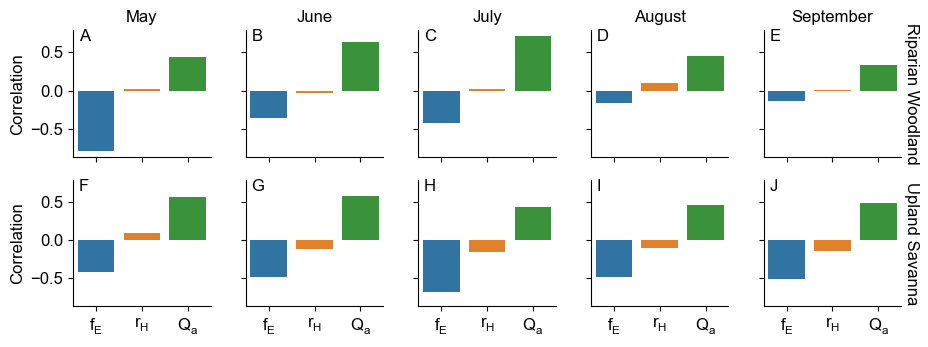

In [92]:
plt.rcParams['font.family'] = 'Arial'

p = sns.catplot(x = "variable", y = "value", col = "month", row = 'site', data = corr_summ_TL_TA, kind = "bar", margin_titles = True, height = 9.44882/5, aspect = 1)
p.set(xlabel = None, ylabel = "Correlation", xticklabels = ['$\mathregular{f_{E}}$', '$\mathregular{r_{H}}$', '$\mathregular{Q_a}$'])
axes = p.axes.flatten()
axes[0].set_title("May")
axes[0].text(0.04, 0.92, "A", transform = axes[0].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[1].set_title("June")
axes[1].text(0.04, 0.92, "B", transform = axes[1].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[2].set_title("July")
axes[2].text(0.04, 0.92, "C", transform = axes[2].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[3].set_title("August")
axes[3].text(0.04, 0.92, "D", transform = axes[3].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[4].set_title("September")
axes[4].text(0.04, 0.92, "E", transform = axes[4].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[5].text(0.04, 0.91, "F", transform = axes[5].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[6].text(0.04, 0.91, "G", transform = axes[6].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[7].text(0.04, 0.91, "H", transform = axes[7].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[8].text(0.04, 0.91, "I", transform = axes[8].transAxes, fontsize = 'medium', fontweight = 'normal')
axes[9].text(0.04, 0.91, "J", transform = axes[9].transAxes, fontsize = 'medium', fontweight = 'normal')

label_dict = {'CMW':'Riparian Woodland', 'SRM': 'Upland Savanna'}

for margin_title in p._margin_titles_texts:
    margin_title.set_text(label_dict[margin_title.get_text()[7:]])

plt.show()

In [93]:
p.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\tc_ta_drivers.pdf')

## Correlations with Environmental Variables:

Calculate correlations between environmental variables and model terms:

In [94]:
CMW_env_corr = CMW_Eddy_Covariance_daytime.copy()[['Rn_G', 'Evap_Frac', 'opt_rha', 'SW_IN', 'VPD_1_2_1', 'WS_1_2_1', 'SWC_PI_1_3_A']].dropna() #SWC 22.5 cm
CMW_env_corr.corr(method = 'spearman', numeric_only = True).loc[['Evap_Frac', 'opt_rha', 'Rn_G'], :].drop(['Evap_Frac', 'opt_rha', 'Rn_G'], axis = 1).round(2)

,SW_IN,VPD_1_2_1,WS_1_2_1,SWC_PI_1_3_A
Evap_Frac,-0.39,-0.15,-0.36,0.02
opt_rha,-0.15,-0.21,-0.73,0.12
Rn_G,0.86,0.27,0.15,-0.02


In [95]:
SRM_env_corr = SRM_Eddy_Covariance_daytime.copy()[['Rn_G', 'Evap_Frac', 'opt_rha', 'SW_IN', 'VPD_1_2_1', 'WS_1_2_1', 'SWC_PI_1_3_A']].dropna() #SWC 20 cm
SRM_env_corr.corr(method = 'spearman', numeric_only = True).loc[['Evap_Frac', 'opt_rha', 'Rn_G'], :].drop(['Evap_Frac', 'opt_rha', 'Rn_G'], axis = 1).round(2)

,SW_IN,VPD_1_2_1,WS_1_2_1,SWC_PI_1_3_A
Evap_Frac,-0.36,-0.34,-0.40,0.76
opt_rha,-0.08,-0.02,-0.66,0.04
Rn_G,0.91,0.20,0.27,0.07


# Evaporative Cooling

## Calculate TL,nc Using Quartic Formula

Charleston Mesquite Woodland

In [96]:
CMW_evap_cooling = CMW_Eddy_Covariance_daytime.copy()
CMW_evap_cooling = CMW_evap_cooling.dropna(subset = ['SW_IN', 'SW_OUT', 'LW_IN', 'G', 'TA_1_2_1', 'opt_rha', 'rho'])
CMW_evap_cooling['tlnc'] = CMW_evap_cooling.apply(lambda x: calc_quartic_tlnc(x), axis = 1)
CMW_evap_cooling['tl_tlnc'] = CMW_evap_cooling.tlnc - CMW_evap_cooling.tc_pred
CMW_evap_cooling = CMW_evap_cooling[CMW_evap_cooling.tl_tlnc >= 0]

In [97]:
CMW_evap_cooling_summ = CMW_evap_cooling[['tl_tlnc', 'month', 'time']].groupby(['month', 'time']).mean().reset_index()

Santa Rita Mesquite

In [98]:
SRM_evap_cooling = SRM_Eddy_Covariance_daytime.copy()
SRM_evap_cooling = SRM_evap_cooling.dropna(subset = ['SW_IN', 'SW_OUT', 'LW_IN', 'G', 'TA_1_2_1', 'opt_rha', 'rho'])
SRM_evap_cooling['tlnc'] = SRM_evap_cooling.apply(lambda x: calc_quartic_tlnc(x), axis = 1)
SRM_evap_cooling['tl_tlnc'] = SRM_evap_cooling.tlnc - SRM_evap_cooling.tc_pred
SRM_evap_cooling = SRM_evap_cooling[SRM_evap_cooling.tl_tlnc >= 0]

In [99]:
SRM_evap_cooling_summ = SRM_evap_cooling[['tl_tlnc', 'month', 'time']].groupby(['month', 'time']).mean().reset_index()

## Calculate TL-TL,nc Climatology

Maximum daily TL-TL,nc in May and August:

In [100]:
CMW_evap_cooling_summ[CMW_evap_cooling_summ.month == 5].max()['tl_tlnc'].round(2)

1.45

In [101]:
CMW_evap_cooling_summ[CMW_evap_cooling_summ.month == 8].max()['tl_tlnc'].round(2)

4.81

In [102]:
SRM_evap_cooling_summ[CMW_evap_cooling_summ.month == 5].max()['tl_tlnc'].round(2)

1.14

In [103]:
SRM_evap_cooling_summ[CMW_evap_cooling_summ.month == 8].max()['tl_tlnc'].round(2)

3.35

## Plot Diurnal Curves

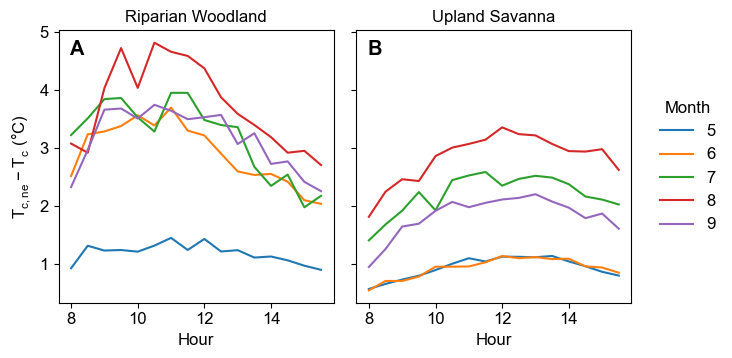

In [104]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

f, axs = plt.subplots(1, 2, sharex=True, sharey = True, figsize = (190 / constants.inch /1000, 190 / constants.inch /1000 * (3.5/7)))
sns.lineplot(x = 'time', y = 'tl_tlnc', hue = 'month', data = CMW_evap_cooling_summ, palette = "tab10", ax=axs[0])
axs[0].set(xlabel = 'Hour', ylabel = '$\mathregular{T_{c,ne} - T_c}$ (°C)', title = 'Riparian Woodland')
axs[0].legend_.remove()
axs[0].text(0.04, 0.91, "A", transform = axs[0].transAxes, fontsize = 'large', fontweight = 'bold')

sns.lineplot(x = 'time', y = 'tl_tlnc', hue = 'month', data = SRM_evap_cooling_summ, palette = "tab10", ax=axs[1])
axs[1].set(title = 'Upland Savanna', xlabel = 'Hour')
axs[1].legend(loc = 'center left', bbox_to_anchor = (1.05, 0.5), ncol = 1, title = 'Month', frameon = False)
axs[1].set_xticks(np.arange(8, 16, 2))
axs[1].text(0.04, 0.91, "B", transform = axs[1].transAxes, fontsize = 'large', fontweight = 'bold')

f.tight_layout()

In [105]:
f.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\evap_cooling.pdf')

### Check solutions by backsolving for air temperature

In [106]:
#Equation 22 but solve for TA
def check_tlnc(TL, SWd, SWup, LWd, G, rha, rho, cp, emiss = 0.98):
    top = (SWd - SWup + (emiss * LWd) - (emiss * constants.sigma * (TL**4)) - G) * rha
    bottom = rho * cp
    TA = TL - (top/bottom)
    return TA

Checking needs to be done in Kelvin as well!

In [107]:
CMW_tlnc_check = check_tlnc(TL = CMW_evap_cooling.tlnc + 273.15, 
           SWd = CMW_evap_cooling.SW_IN, 
           SWup = CMW_evap_cooling.SW_OUT, 
           LWd = CMW_evap_cooling.LW_IN,
           G = CMW_evap_cooling.G, 
           rha = CMW_evap_cooling.opt_rha, 
           rho = CMW_evap_cooling.rho, 
           cp = CMW_evap_cooling.cp) - 273.15

CMW_tlnc_check

time_start
2001-05-01 08:00:00-07:00    20.0600
2001-05-01 09:00:00-07:00    25.3950
2001-05-01 10:00:00-07:00    27.4350
2001-05-01 10:30:00-07:00    28.4000
2001-05-01 11:00:00-07:00    29.1350
                              ...   
2003-09-30 13:00:00-07:00    35.1259
2003-09-30 13:30:00-07:00    35.3070
2003-09-30 14:00:00-07:00    36.3211
2003-09-30 14:30:00-07:00    35.8500
2003-09-30 15:00:00-07:00    35.2832
Length: 3391, dtype: float64

In [108]:
CMW_evap_cooling.TA_1_2_1

time_start
2001-05-01 08:00:00-07:00    20.0600
2001-05-01 09:00:00-07:00    25.3950
2001-05-01 10:00:00-07:00    27.4350
2001-05-01 10:30:00-07:00    28.4000
2001-05-01 11:00:00-07:00    29.1350
                              ...   
2003-09-30 13:00:00-07:00    35.1259
2003-09-30 13:30:00-07:00    35.3070
2003-09-30 14:00:00-07:00    36.3211
2003-09-30 14:30:00-07:00    35.8500
2003-09-30 15:00:00-07:00    35.2832
Name: TA_1_2_1, Length: 3391, dtype: float64

In [109]:
np.mean(np.abs(CMW_tlnc_check - CMW_evap_cooling.TA_1_2_1))

8.24384631465928e-14

In [110]:
SRM_tlnc_check = check_tlnc(TL = SRM_evap_cooling.tlnc + 273.15, 
           SWd = SRM_evap_cooling.SW_IN, 
           SWup = SRM_evap_cooling.SW_OUT, 
           LWd = SRM_evap_cooling.LW_IN,
           G = SRM_evap_cooling.G, 
           rha = SRM_evap_cooling.opt_rha, 
           rho = SRM_evap_cooling.rho, 
           cp = SRM_evap_cooling.cp) - 273.15

SRM_tlnc_check

time_start
2007-05-01 08:00:00-07:00    25.46
2007-05-01 08:30:00-07:00    26.67
2007-05-01 09:00:00-07:00    27.11
2007-05-01 09:30:00-07:00    27.61
2007-05-01 10:00:00-07:00    28.28
                             ...  
2019-09-30 13:30:00-07:00    30.37
2019-09-30 14:00:00-07:00    30.96
2019-09-30 14:30:00-07:00    31.54
2019-09-30 15:00:00-07:00    31.39
2019-09-30 15:30:00-07:00    31.39
Length: 12156, dtype: float64

In [111]:
SRM_evap_cooling.TA_1_2_1

time_start
2007-05-01 08:00:00-07:00    25.46
2007-05-01 08:30:00-07:00    26.67
2007-05-01 09:00:00-07:00    27.11
2007-05-01 09:30:00-07:00    27.61
2007-05-01 10:00:00-07:00    28.28
                             ...  
2019-09-30 13:30:00-07:00    30.37
2019-09-30 14:00:00-07:00    30.96
2019-09-30 14:30:00-07:00    31.54
2019-09-30 15:00:00-07:00    31.39
2019-09-30 15:30:00-07:00    31.39
Name: TA_1_2_1, Length: 12156, dtype: float64

In [112]:
np.mean(np.abs(SRM_tlnc_check - SRM_evap_cooling.TA_1_2_1))

8.525212271711638e-14

# Model Foliar Respiration

## Change in Respiration Due to Evaporative Cooling

In [113]:
CMW_resp_light_summ, CMW_resp_light_monthly = carbonDifference(CMW_evap_cooling, 
                                                               tc_col = 'tc_pred', 
                                                               tcnc_col = 'tlnc', 
                                                               Rtref = 1.7,
                                                               ref_temp = 25)

SRM_resp_light_summ, SRM_resp_light_monthly = carbonDifference(SRM_evap_cooling, 
                                                               tc_col = 'tc_pred', 
                                                               tcnc_col = 'tlnc', 
                                                               Rtref = 1.7,
                                                               ref_temp = 25)

### Summarize Values by Site and Month

In [114]:
CMW_resp_light_monthly

resp_tc  resp_tcnc  resp_diff  resp_perc_change
month year                                                  
5     2001  2.787435   3.140329   0.352894         10.696819
      2002  2.690111   2.848876   0.158765          5.417646
      2003  2.627864   2.912017   0.284153          8.925423
6     2001  2.888667   3.597205   0.708537         19.039244
      2002  3.513864   4.079743   0.565878         13.846467
      2003  2.932706   3.674049   0.741344         19.844224
7     2001  1.853383   2.397752   0.544370         20.702109
      2002  3.515048   4.110365   0.595318         14.806629
      2003  3.506836   4.419153   0.912317         20.766838
8     2001  2.685910   3.416794   0.730884         21.633542
      2002  2.981375   3.812486   0.831111         21.038808
      2003  3.002432   3.964798   0.962366         24.336947
9     2001  2.677786   3.301186   0.623400         18.256567
      2002  2.520843   3.138727   0.617883         19.160806
      2003  2.782123   3.514621   0.732498         20.405987

In [115]:
SRM_resp_light_monthly

resp_tc  resp_tcnc  resp_diff  resp_perc_change
month year                                                  
5     2007  3.248029   3.477790   0.229762          6.456313
      2008  2.712284   2.897692   0.185408          6.190602
      2009  3.679874   3.868156   0.188282          4.768662
      2010  2.963192   3.195684   0.232492          7.247488
      2011  2.754625   2.896171   0.141547          4.807527
      2012  3.442100   3.653009   0.210909          5.701467
      2016  2.863117   3.053294   0.190177          6.360769
      2017  3.069027   3.193611   0.124584          4.064660
      2018  3.215160   3.434633   0.219473          6.299725
      2019  2.016260   2.274551   0.258291         10.796718
6     2007  4.621075   4.866853   0.245778          5.095100
      2008  4.558639   4.837529   0.278890          5.875565
      2009  3.474513   3.634411   0.159899          4.376374
      2010  4.557926   4.794033   0.236108          5.002662
      2011  4.433788   4.628606   0.194819          4.224260
      2012  4.571491   4.830165   0.258674          5.377135
      2013  4.951458   5.130959   0.179501          3.301804
      2016  4.492877   4.722737   0.229860          5.174929
      2017  4.952793   5.150182   0.197389          3.871967
      2018  4.526944   5.046624   0.519680         10.031317
      2019  3.932766   4.263246   0.330480          7.612589
7     2007  4.577557   4.922215   0.344658          7.492347
      2008  3.685058   5.372196   1.687138         31.057328
      2009  4.668110   5.306875   0.638765         11.831406
      2010  4.153321   4.495494   0.342173          7.542427
      2011  3.837215   4.633188   0.795973         16.747420
      2012  3.817193   4.465864   0.648671         13.977791
      2013  3.640693   4.086533   0.445840         10.762168
      2016  4.540585   5.453425   0.912840         16.361885
      2017  4.627502   5.068213   0.440711          8.316049
      2018  4.143279   4.872174   0.728895         13.771143
      2019  4.244621   4.490649   0.246028          5.474856
8     2007  2.920053   4.166142   1.246089         27.861180
      2008  3.426221   4.493680   1.067459         23.576956
      2009  4.356088   4.667421   0.311333          6.705408
      2010  4.413535   5.543685   1.130151         19.937194
      2011  3.934417   4.693826   0.759409         14.564116
      2012  4.172095   4.764411   0.592316         11.667211
      2013  3.821939   4.626863   0.804924         16.180604
      2016  3.373680   4.243978   0.870298         19.636908
      2018  3.618424   4.589811   0.971387         20.492445
      2019  4.594158   5.192132   0.597974         11.872913
9     2007  3.285800   3.566497   0.280697          8.091055
      2008  2.816114   3.393724   0.577610         15.157191
      2009  3.523673   3.685053   0.161380          4.362191
      2010  3.797804   4.297131   0.499327         11.745673
      2011  3.455751   4.166300   0.710548         17.475453
      2012  2.784312   3.231606   0.447294         12.475211
      2013  3.191895   3.476268   0.284373          7.842401
      2016  3.242226   3.842896   0.600670         14.792812
      2017  2.782351   2.910983   0.128632          4.527700
      2018  3.204394   3.980984   0.776590         18.837610
      2019  2.879314   3.247398   0.368084         10.910301

### Plot Results

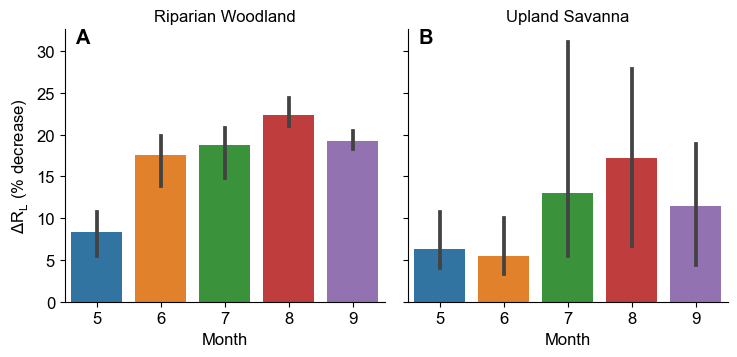

In [116]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=12)   # controls default text sizes
plt.rc('axes', titlesize=12)  # fontsize of the axes title

CMW_plt_vals = CMW_resp_light_monthly.reset_index()
CMW_plt_vals['site'] = 'Riparian Woodland'
SRM_plt_vals = SRM_resp_light_monthly.reset_index()
SRM_plt_vals['site'] = 'Upland Savanna'
plt_vals = pd.concat([CMW_plt_vals, SRM_plt_vals])

p = sns.catplot(data = plt_vals, kind = 'bar', x = 'month', y = 'resp_perc_change', col = 'site', errorbar = ("pi", 100), palette = 'tab10', height = 7.48031/2, aspect = 1)

p.set(ylabel = 'ΔR$\mathregular{_{L}}$ (% decrease)', xlabel = 'Month')

for col_key,ax in p.axes_dict.items():
    ax.set_title(f"{col_key}")

plot_labs = ['A', 'B']
    
for ax, title in zip(p.axes.flat, plot_labs):
    ax.text(-0.1, 31, title, fontsize = 'large', fontweight = 'bold', horizontalalignment = 'right') #add text  
    
plt.show()

In [117]:
p.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\combined_respiration.pdf')

# Climate Summary

In [118]:
def climateYearlySum(path):
    vals = pd.read_csv(path, skiprows = 1, names = ['Date', 'Value'], parse_dates = [0])
    vals['year'] = vals.Date.dt.year
    vals = vals[vals.year != 2022]
    yearly_sum = vals.groupby(['year']).sum(numeric_only = True).reset_index()
    return yearly_sum

def climateMonthlyValues(path):
    vals = pd.read_csv(path, skiprows = 1, names = ['Date', 'Value'], parse_dates = [0])
    vals['month'] = vals.Date.dt.month
    vals['year'] = vals.Date.dt.year
    vals = vals[vals.year != 2022]
    return vals

### Charleston Mesquite Woodland

Mean annual precipitation

In [119]:
climateYearlySum('Climate/CMW_Precip.csv').mean().round(2).Value

318.98

Monthly Precipitation

In [120]:
CMW_monthly_precip = climateMonthlyValues('Climate/CMW_Precip.csv').reset_index()
CMW_monthly_precip['site'] = 'CMW'

Mean summer temperature

In [121]:
CMW_mean_temp = climateMonthlyValues('Climate/CMW_MeanTemp.csv').reset_index()
CMW_mean_temp = CMW_mean_temp[(CMW_mean_temp.month > 4) & (CMW_mean_temp.month < 10)]
CMW_mean_temp.Value.mean().round(2)

24.53

### Santa Rita Mesquite

Mean annual precipitation

In [122]:
climateYearlySum('Climate/SRM_Precip.csv').mean().round(2).Value

368.07

Monthly Precipitation

In [123]:
SRM_monthly_precip = climateMonthlyValues('Climate/SRM_Precip.csv').reset_index()
SRM_monthly_precip['site'] = 'SRM'

Mean summer temperature

In [124]:
SRM_mean_temp = climateMonthlyValues('Climate/SRM_MeanTemp.csv').reset_index()
SRM_mean_temp = SRM_mean_temp[(SRM_mean_temp.month > 4) & (SRM_mean_temp.month < 10)]
SRM_mean_temp.Value.mean().round(2)

25.57

### Both Sites

#### Precipitation

In [125]:
both_sites_monthly_precip = pd.concat([CMW_monthly_precip, SRM_monthly_precip])
both_sites_monthly_precip = both_sites_monthly_precip[(both_sites_monthly_precip.month >= 5) & (both_sites_monthly_precip.month <= 9)]

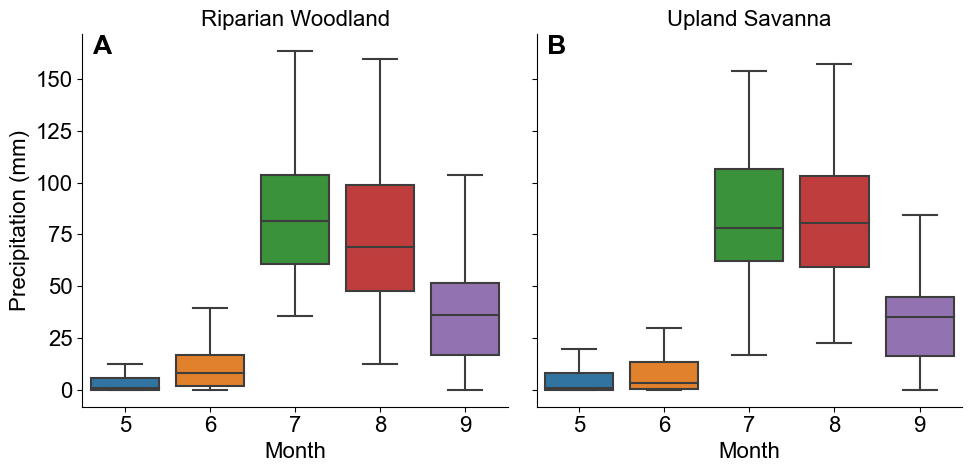

In [126]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=16)   # controls default text sizes
plt.rc('axes', titlesize=16)  # fontsize of the axes title

b = sns.catplot(both_sites_monthly_precip, x = 'month', y = 'Value', col = 'site', kind = 'box', showfliers = False)

b.set_xlabels('Month')
b.set_ylabels('Precipitation (mm)')
axes = b.axes.flatten()
axes[0].set_title("Riparian Woodland")
axes[1].set_title("Upland Savanna")

plot_labs = ['A', 'B']
    
for ax, title in zip(b.axes.flat, plot_labs):
    ax.text(-0.15, 162, title, fontsize = 'large', fontweight = 'bold', horizontalalignment = 'right') #add text  

plt.show()

In [127]:
b.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\precipitation.pdf')

#### Latent Heat Flux

In [128]:
CMW_LE = CMW_Eddy_Covariance_daytime.copy()[['month', 'time', 'LE']]
CMW_LE['site'] = 'CMW'

SRM_LE = SRM_Eddy_Covariance_daytime.copy()[['month', 'time', 'LE']]
SRM_LE['site'] = 'SRM'

LE_vals = pd.concat([CMW_LE, SRM_LE])

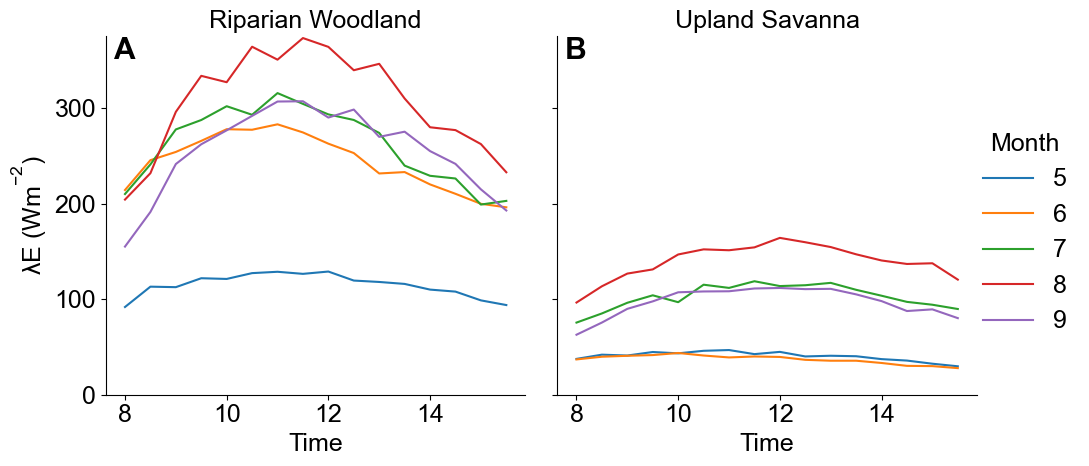

In [129]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=18)   # controls default text sizes
plt.rc('axes', titlesize=18)  # fontsize of the axes title

b = sns.relplot(LE_vals, x = 'time', y = 'LE', hue = 'month', col = 'site', kind = 'line', palette = 'tab10', estimator = 'mean', errorbar = None)
plt.ylim(0, 375)
b.set_xlabels('Time')
b.set_ylabels('$\mathregular{\lambda}$E $\mathregular{(Wm^{-2})}$')
b._legend.set_title('Month')
axes = b.axes.flatten()
axes[0].set_title("Riparian Woodland")
axes[1].set_title("Upland Savanna")

plot_labs = ['A', 'B']
    
for ax, title in zip(b.axes.flat, plot_labs):
    ax.text(8.2, 351, title, fontsize = 'large', fontweight = 'bold', horizontalalignment = 'right') #add text  

plt.show()

In [130]:
b.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\lhf_climatology.pdf')

#### Soil Moisture

In [131]:
CMW_SWC = CMW_Eddy_Covariance_daytime.copy()[['month', 'SWC_PI_1_3_A']]
CMW_SWC['site'] = 'CMW'

SRM_SWC = SRM_Eddy_Covariance_daytime.copy()[['month', 'SWC_PI_1_3_A']]
SRM_SWC['site'] = 'SRM'

SWC_vals = pd.concat([CMW_SWC, SRM_SWC])

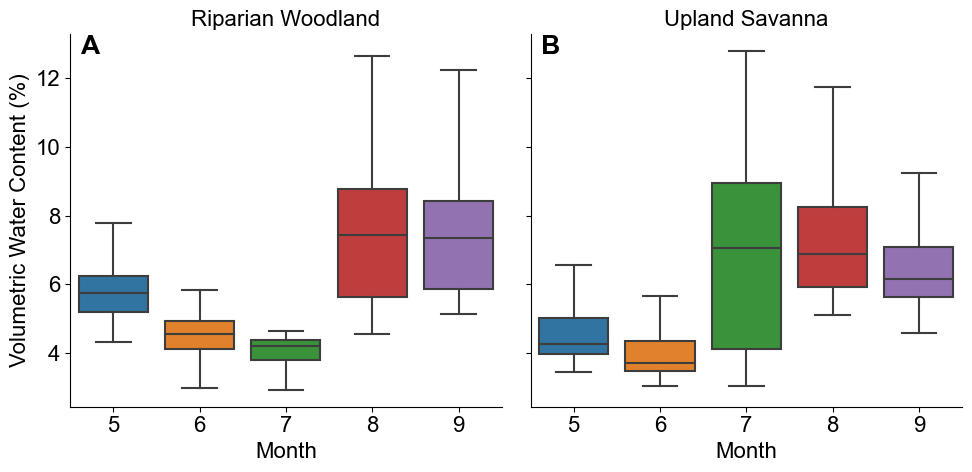

In [132]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=16)   # controls default text sizes
plt.rc('axes', titlesize=16)  # fontsize of the axes title

b = sns.catplot(SWC_vals, x = 'month', y = 'SWC_PI_1_3_A', col = 'site', kind = 'box', showfliers = False)

b.set_xlabels('Month')
b.set_ylabels('Volumetric Water Content (%)')
axes = b.axes.flatten()
axes[0].set_title("Riparian Woodland")
axes[1].set_title("Upland Savanna")

plot_labs = ['A', 'B']
    
for ax, title in zip(b.axes.flat, plot_labs):
    ax.text(-0.15, 12.7, title, fontsize = 'large', fontweight = 'bold', horizontalalignment = 'right') #add text  

plt.show()

In [133]:
b.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\vwc_climatology.pdf')

# T/ET Analysis

## Charleston Mesquite Woodland

Open transpiration data from Scott et al. (2021) and calculate T/ET for CMW

In [134]:
CMW_transpiration = pd.read_csv('DailyTEA_CM_Kibler.csv')
CMW_transpiration['date'] = pd.to_datetime(CMW_transpiration['Year'].astype(str) + "-" + CMW_transpiration['DOY'].astype(str), format='%Y-%j')
CMW_transpiration['year'] = CMW_transpiration.date.dt.year
CMW_transpiration['month'] = CMW_transpiration.date.dt.month
CMW_transpiration['day'] = CMW_transpiration.date.dt.day
CMW_transpiration['TET_TEA'] = CMW_transpiration['TEA_T']/CMW_transpiration['ET']
CMW_transpiration = CMW_transpiration.dropna(subset = 'TET_TEA')
CMW_transpiration['site'] = 'US-CMW'

NOTE: December 31 is dropped in leap years, so there are 365 day records in every year. This doesn't actually affect the analysis because the data sets overlap in 2005 and 2006, and the first leap year occurs in 2008.

Calculate all unique days in the Ameriflux dataset and merge it with the daily transpiration estimates

In [135]:
unique_days_CMW = CMW_Eddy_Covariance_daytime.groupby(['year', 'month', 'day']).first().reset_index()
CMW_tet = pd.merge(CMW_transpiration, unique_days_CMW, on = ['year', 'month', 'day'], how = 'inner')

Calculate the average daily T/ET by month

In [136]:
CMW_tet[['TET_TEA', 'month']].groupby('month').median().round(2)

,TET_TEA
month,
5,0.89
6,0.91
7,0.90
8,0.87
9,0.92


## Santa Rita Mesquite

Open transpiration data from Nelson et al. (2020) and calculate T/ET for SRM

NOTE: All years contain 366 days. DOY 366 defaults to January 1 on non-leap years.

In [137]:
srm_transpiration = xr.open_dataset('daily_t_Nelson_2020.nc').load().sel(site = "US-SRM").to_dataframe().reset_index()
srm_transpiration = srm_transpiration[np.logical_not(np.logical_not(srm_transpiration.year.isin([1992, 1996, 2000, 2004, 2008, 2012, 2016, 2020])) & 
                                                     (srm_transpiration.doy == 366))] #Remove DOY 366 for non-leap years
srm_transpiration['date'] = pd.to_datetime(srm_transpiration['year'].astype(str) + "-" + srm_transpiration['doy'].astype(str), format='%Y-%j')
srm_transpiration['year'] = srm_transpiration.date.dt.year
srm_transpiration['month'] = srm_transpiration.date.dt.month
srm_transpiration['day'] = srm_transpiration.date.dt.day
srm_transpiration['TET_TEA'] = srm_transpiration['TEA_T']/srm_transpiration['ET']
srm_transpiration = srm_transpiration.dropna(subset = 'TET_TEA')

Calculate all unique days in the Ameriflux dataset and merge it with the daily transpiration estimates

In [138]:
unique_days_SRM = SRM_Eddy_Covariance_daytime.groupby(['year', 'month', 'day']).first().reset_index()
SRM_tet = pd.merge(srm_transpiration, unique_days_SRM, on = ['year', 'month', 'day'], how = 'inner')

Calculate the average daily T/ET by month

In [139]:
SRM_tet[['TET_TEA', 'month']].groupby('month').median().round(2)

,TET_TEA
month,
5,0.78
6,0.72
7,0.74
8,0.80
9,0.79


## Both Sites

In [140]:
TET_both_sites = pd.concat([CMW_tet[['year', 'month', 'day', 'TET_TEA', 'site']], SRM_tet[['year', 'month', 'day', 'TET_TEA', 'site']]])

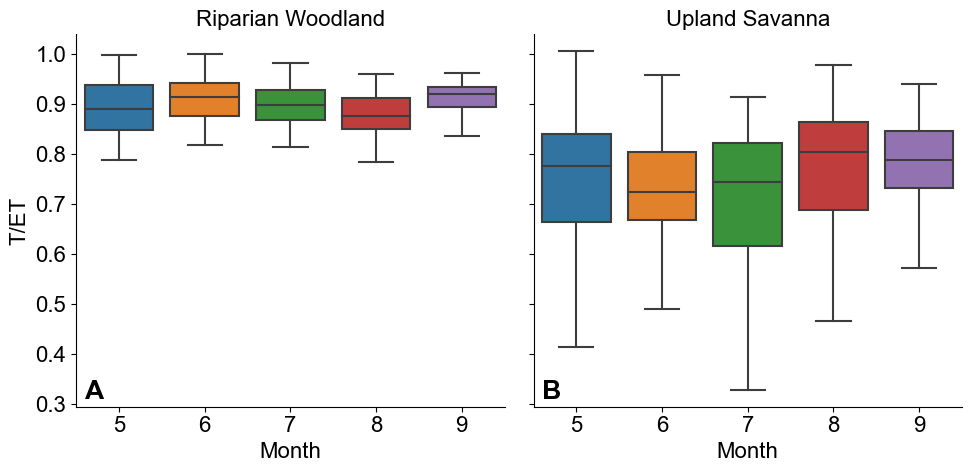

In [141]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=16)   # controls default text sizes
plt.rc('axes', titlesize=16)  # fontsize of the axes title

b = sns.catplot(data = TET_both_sites, x = 'month', y = 'TET_TEA', hue = 'month', col = 'site', kind = 'box', showfliers = False, dodge = False)
b.set_xlabels('Month')
b.set_ylabels('T/ET')
axes = b.axes.flatten()
axes[0].set_title("Riparian Woodland")
axes[1].set_title("Upland Savanna")

plot_labs = ['A', 'B']
    
for ax, title in zip(b.axes.flat, plot_labs):
    ax.text(-0.4, 0.31, title, fontsize = 'large', fontweight = 'bold', horizontalalignment = 'left') #add text  

#plt.ylim(0, 1.25)
plt.show()

In [142]:
b.savefig('F:\Research\Evapotranspiration\Latex\elsarticle\\tet_partitioning.pdf')

# Compare Thermal Infrared Cameras

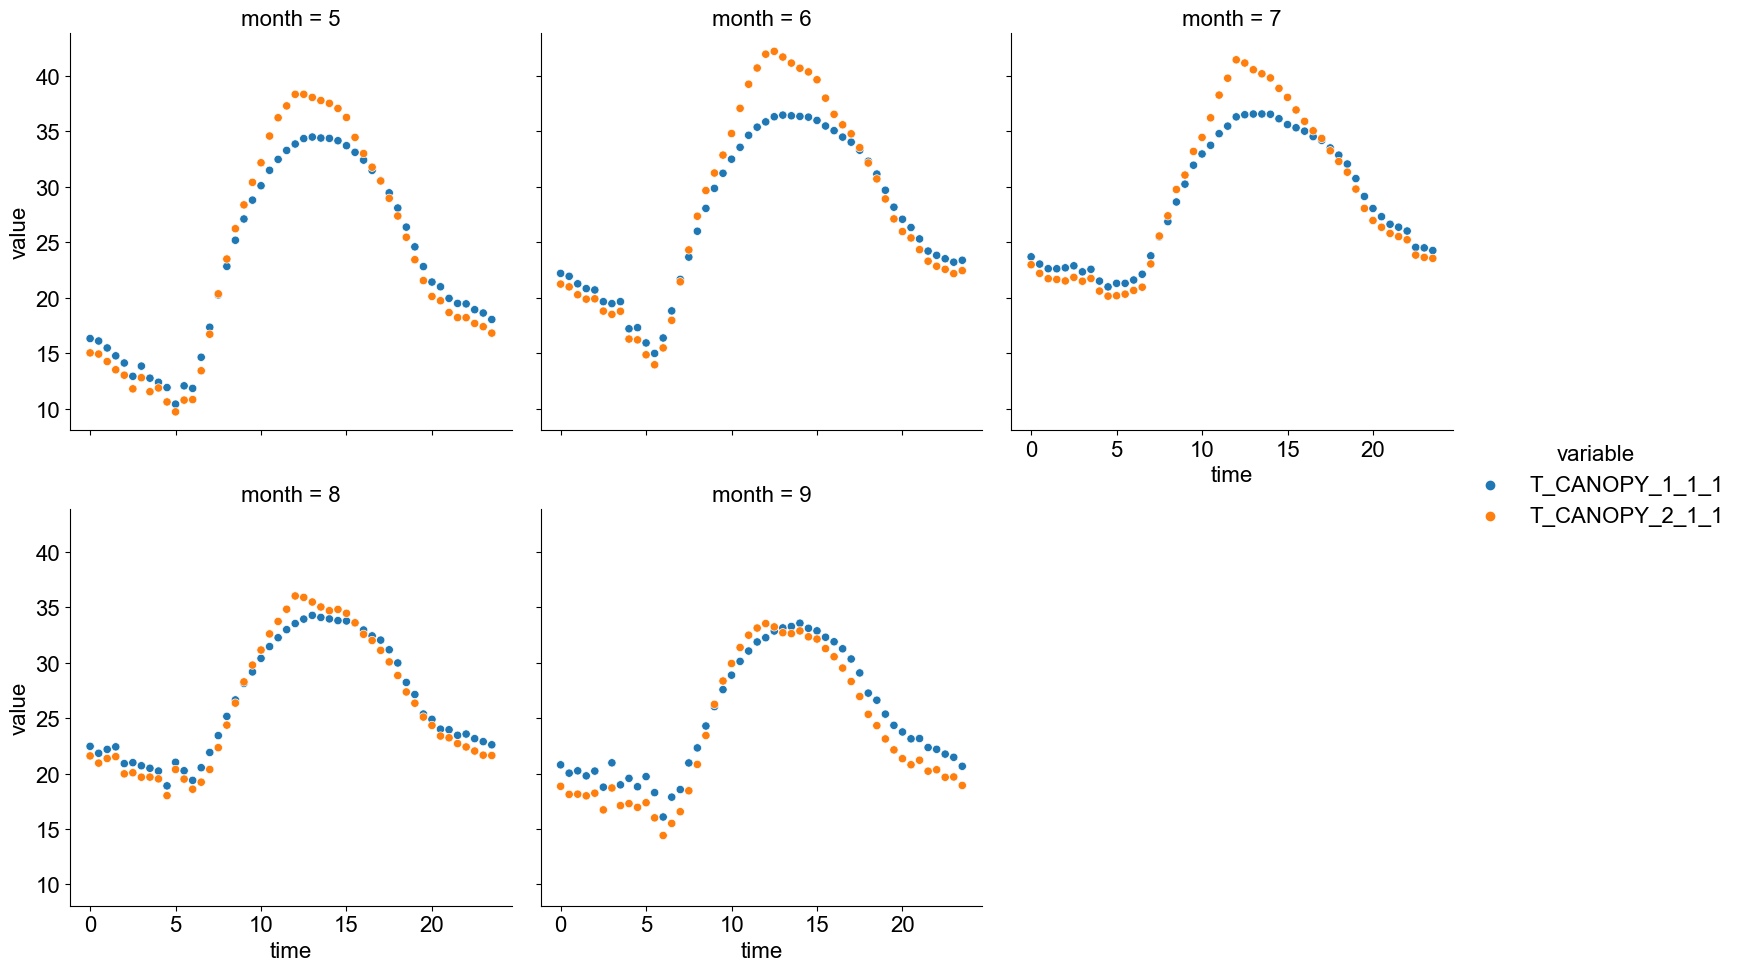

In [143]:
CMW_EC_all = preprocessAmeriflux('CMW/AMF_US-CMW_BASE_HH_1-5.csv',
                                                  heights = 2, 
                                                  ustar_thresh = 0.2, 
                                                  time_start = "0:00", 
                                                  time_end = "23:30", 
                                                  time_zone = 'America/Phoenix')

CMW_EC_all.month = CMW_EC_all.index.month
CMW_EC_all.time = CMW_EC_all.index.hour + (CMW_EC_all.index.minute/60)

CMW_check = CMW_EC_all[['month', 'time', 'T_CANOPY_1_1_1', 'T_CANOPY_2_1_1']]
CMW_check = CMW_check.groupby(['month', 'time']).mean().reset_index().melt(id_vars = ['month', 'time'])

sns.relplot(x = 'time', y = 'value', hue = 'variable', col = 'month', col_wrap = 3, data = CMW_check)
plt.show()

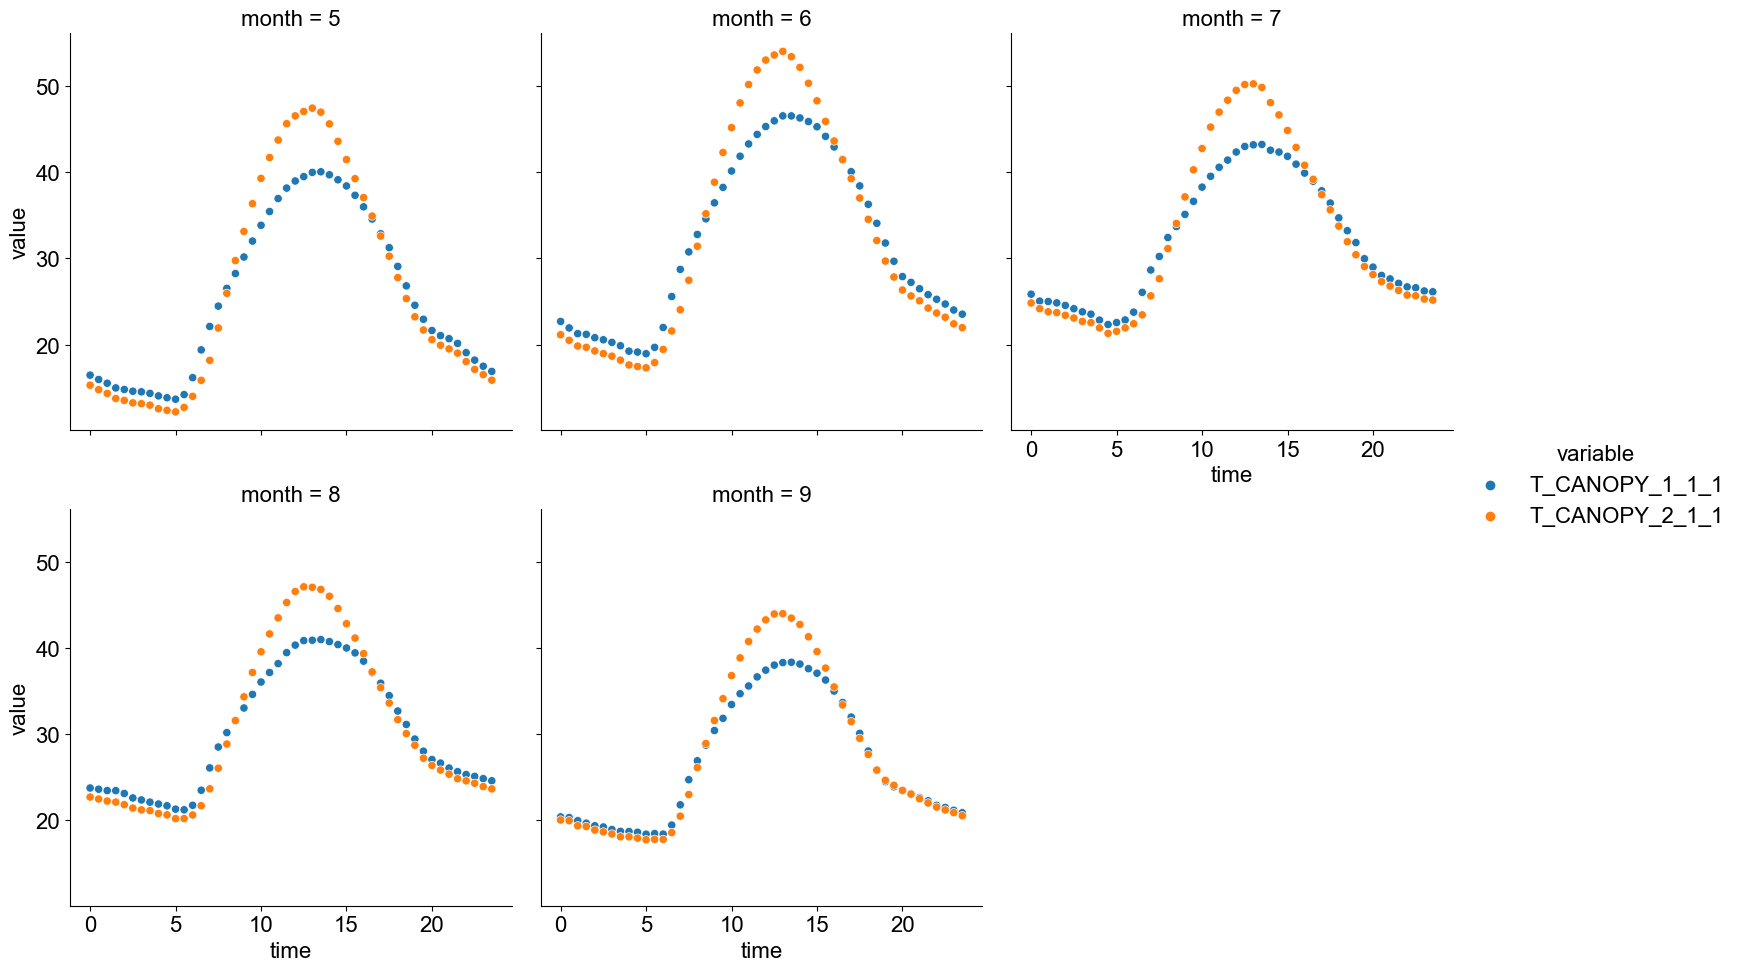

In [144]:
SRM_EC_all = preprocessAmeriflux('SRM/AMF_US-SRM_BASE_HH_22-5.csv', 
                                                  heights = 2, 
                                                  ustar_thresh = 0.2, 
                                                  time_start = "0:00", 
                                                  time_end = "23:30", 
                                                  time_zone = 'America/Phoenix')

SRM_EC_all.month = SRM_EC_all.index.month
SRM_EC_all.time = SRM_EC_all.index.hour + (SRM_EC_all.index.minute/60)

SRM_check = SRM_EC_all[['month', 'time', 'T_CANOPY_1_1_1', 'T_CANOPY_2_1_1']]
SRM_check = SRM_check.groupby(['month', 'time']).mean().reset_index().melt(id_vars = ['month', 'time'])

sns.relplot(x = 'time', y = 'value', hue = 'variable', col = 'month', col_wrap = 3, data = SRM_check)
plt.show()

# Review Replies

## Upland Savanna

In [145]:
SRM_plt_vals = SRM_Eddy_Covariance_daytime.copy()
SRM_plt_vals = SRM_plt_vals[(SRM_plt_vals.Evap_Frac < 1.5) & (SRM_plt_vals.Evap_Frac > -0.25)]
SRM_plt_vals['hour'] = np.floor(SRM_plt_vals.index.hour/2)
SRM_plt_vals['Hour'] = SRM_plt_vals['hour'].astype(str).replace({'4.0':'8:00-10:00', '5.0':'10:00-12:00', '6.0':'12:00-14:00', '7.0':'14:00-16:00'})
SRM_plt_vals['Month'] = SRM_plt_vals['month']

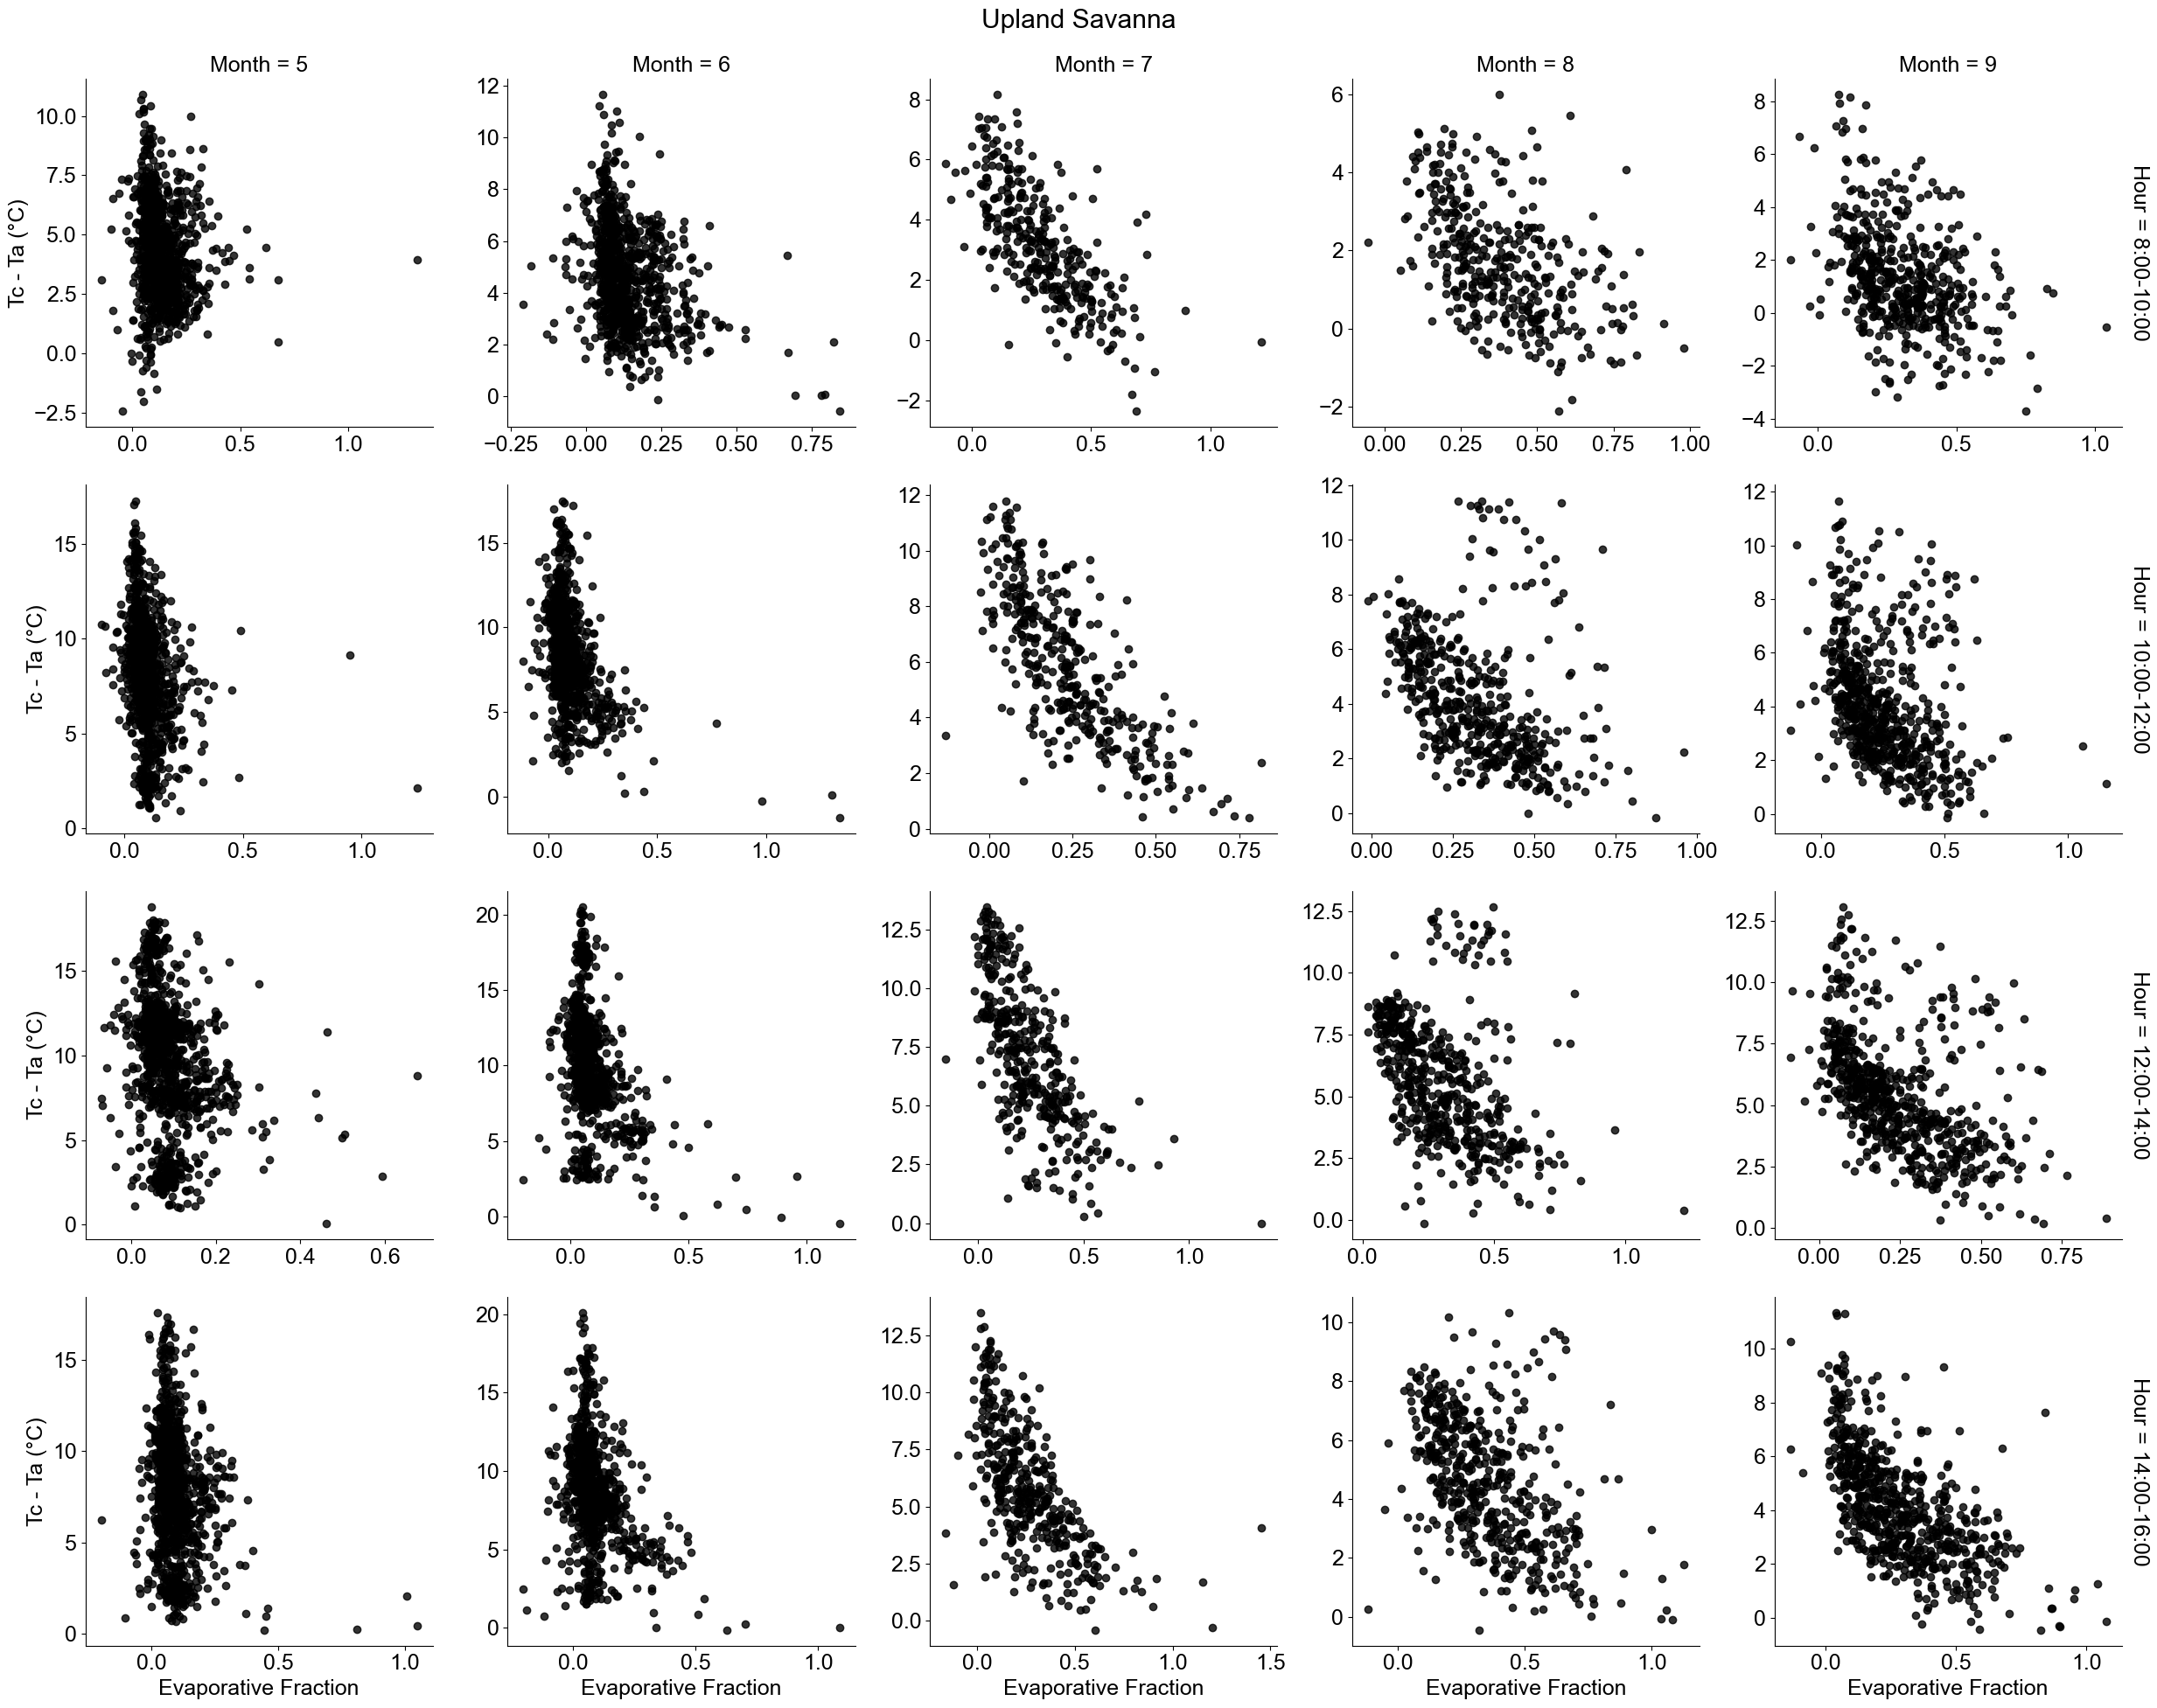

In [146]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=18)   # controls default text sizes
plt.rc('axes', titlesize=18)  # fontsize of the axes title

b = sns.lmplot(SRM_plt_vals, x = 'Evap_Frac', y = 'IR_tc_ta', row = 'Hour', col = 'Month', facet_kws=dict(sharey=False, sharex = False, margin_titles = True), scatter_kws = {'color': 'black'}, fit_reg = False)
b.set_xlabels("Evaporative Fraction")
b.set_ylabels("Tc - Ta (°C)")
plt.subplots_adjust(top=0.94) # adjust the Figure in rp
plt.suptitle('Upland Savanna')
plt.show()

In [147]:
(SRM_plt_vals[['Evap_Frac', 'IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
 .corr()
 .reset_index()
 .groupby(['month', 'hour'])
 .first()
 .reset_index()
 .pivot(index = 'hour', columns = 'month', values = 'IR_tc_ta')
 .round(2))

month,5,6,7,8,9
hour,,,,,
4.0,-0.14,-0.32,-0.70,-0.49,-0.40
5.0,-0.29,-0.42,-0.75,-0.37,-0.34
6.0,-0.28,-0.42,-0.69,-0.40,-0.49
7.0,-0.24,-0.37,-0.66,-0.48,-0.63


In [148]:
(SRM_plt_vals[['Evap_Frac', 'IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
 .corr()
 .reset_index()
 .groupby(['month', 'hour'])
 .first()
 .drop(['level_2'], axis = 1)
 .reset_index().groupby(['month']).mean().round(2))

,hour,Evap_Frac,IR_tc_ta
month,,,
5,5.5,1.0,-0.24
6,5.5,1.0,-0.38
7,5.5,1.0,-0.70
8,5.5,1.0,-0.44
9,5.5,1.0,-0.47


In [149]:
max_ef = (SRM_plt_vals[['Evap_Frac', 'IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
          .max()
          .reset_index()
          .pivot(index = 'hour', columns = 'month', values = 'Evap_Frac'))

In [150]:
min_ef = (SRM_plt_vals[['Evap_Frac', 'IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
          .min()
          .reset_index()
          .pivot(index = 'hour', columns = 'month', values = 'Evap_Frac'))

In [151]:
max_ef - min_ef

month,5,6,7,8,9
hour,,,,,
4.0,1.466144,1.050329,1.326171,1.035625,1.140996
5.0,1.331790,1.448585,0.947441,0.972093,1.278993
6.0,0.748140,1.339473,1.499178,1.202189,0.974567
7.0,1.247858,1.289202,1.615585,1.245252,1.211597


## Riparian Woodland

In [152]:
CMW_plt_vals = CMW_Eddy_Covariance_daytime.copy()
CMW_plt_vals = CMW_plt_vals[(CMW_plt_vals.Evap_Frac < 1.5) & (CMW_plt_vals.Evap_Frac > -0.25)]
CMW_plt_vals['hour'] = np.floor(CMW_plt_vals.index.hour/2)
CMW_plt_vals['Hour'] = CMW_plt_vals['hour'].astype(str).replace({'4.0':'8:00-10:00', '5.0':'10:00-12:00', '6.0':'12:00-14:00', '7.0':'14:00-16:00'})
CMW_plt_vals['Month'] = CMW_plt_vals['month']

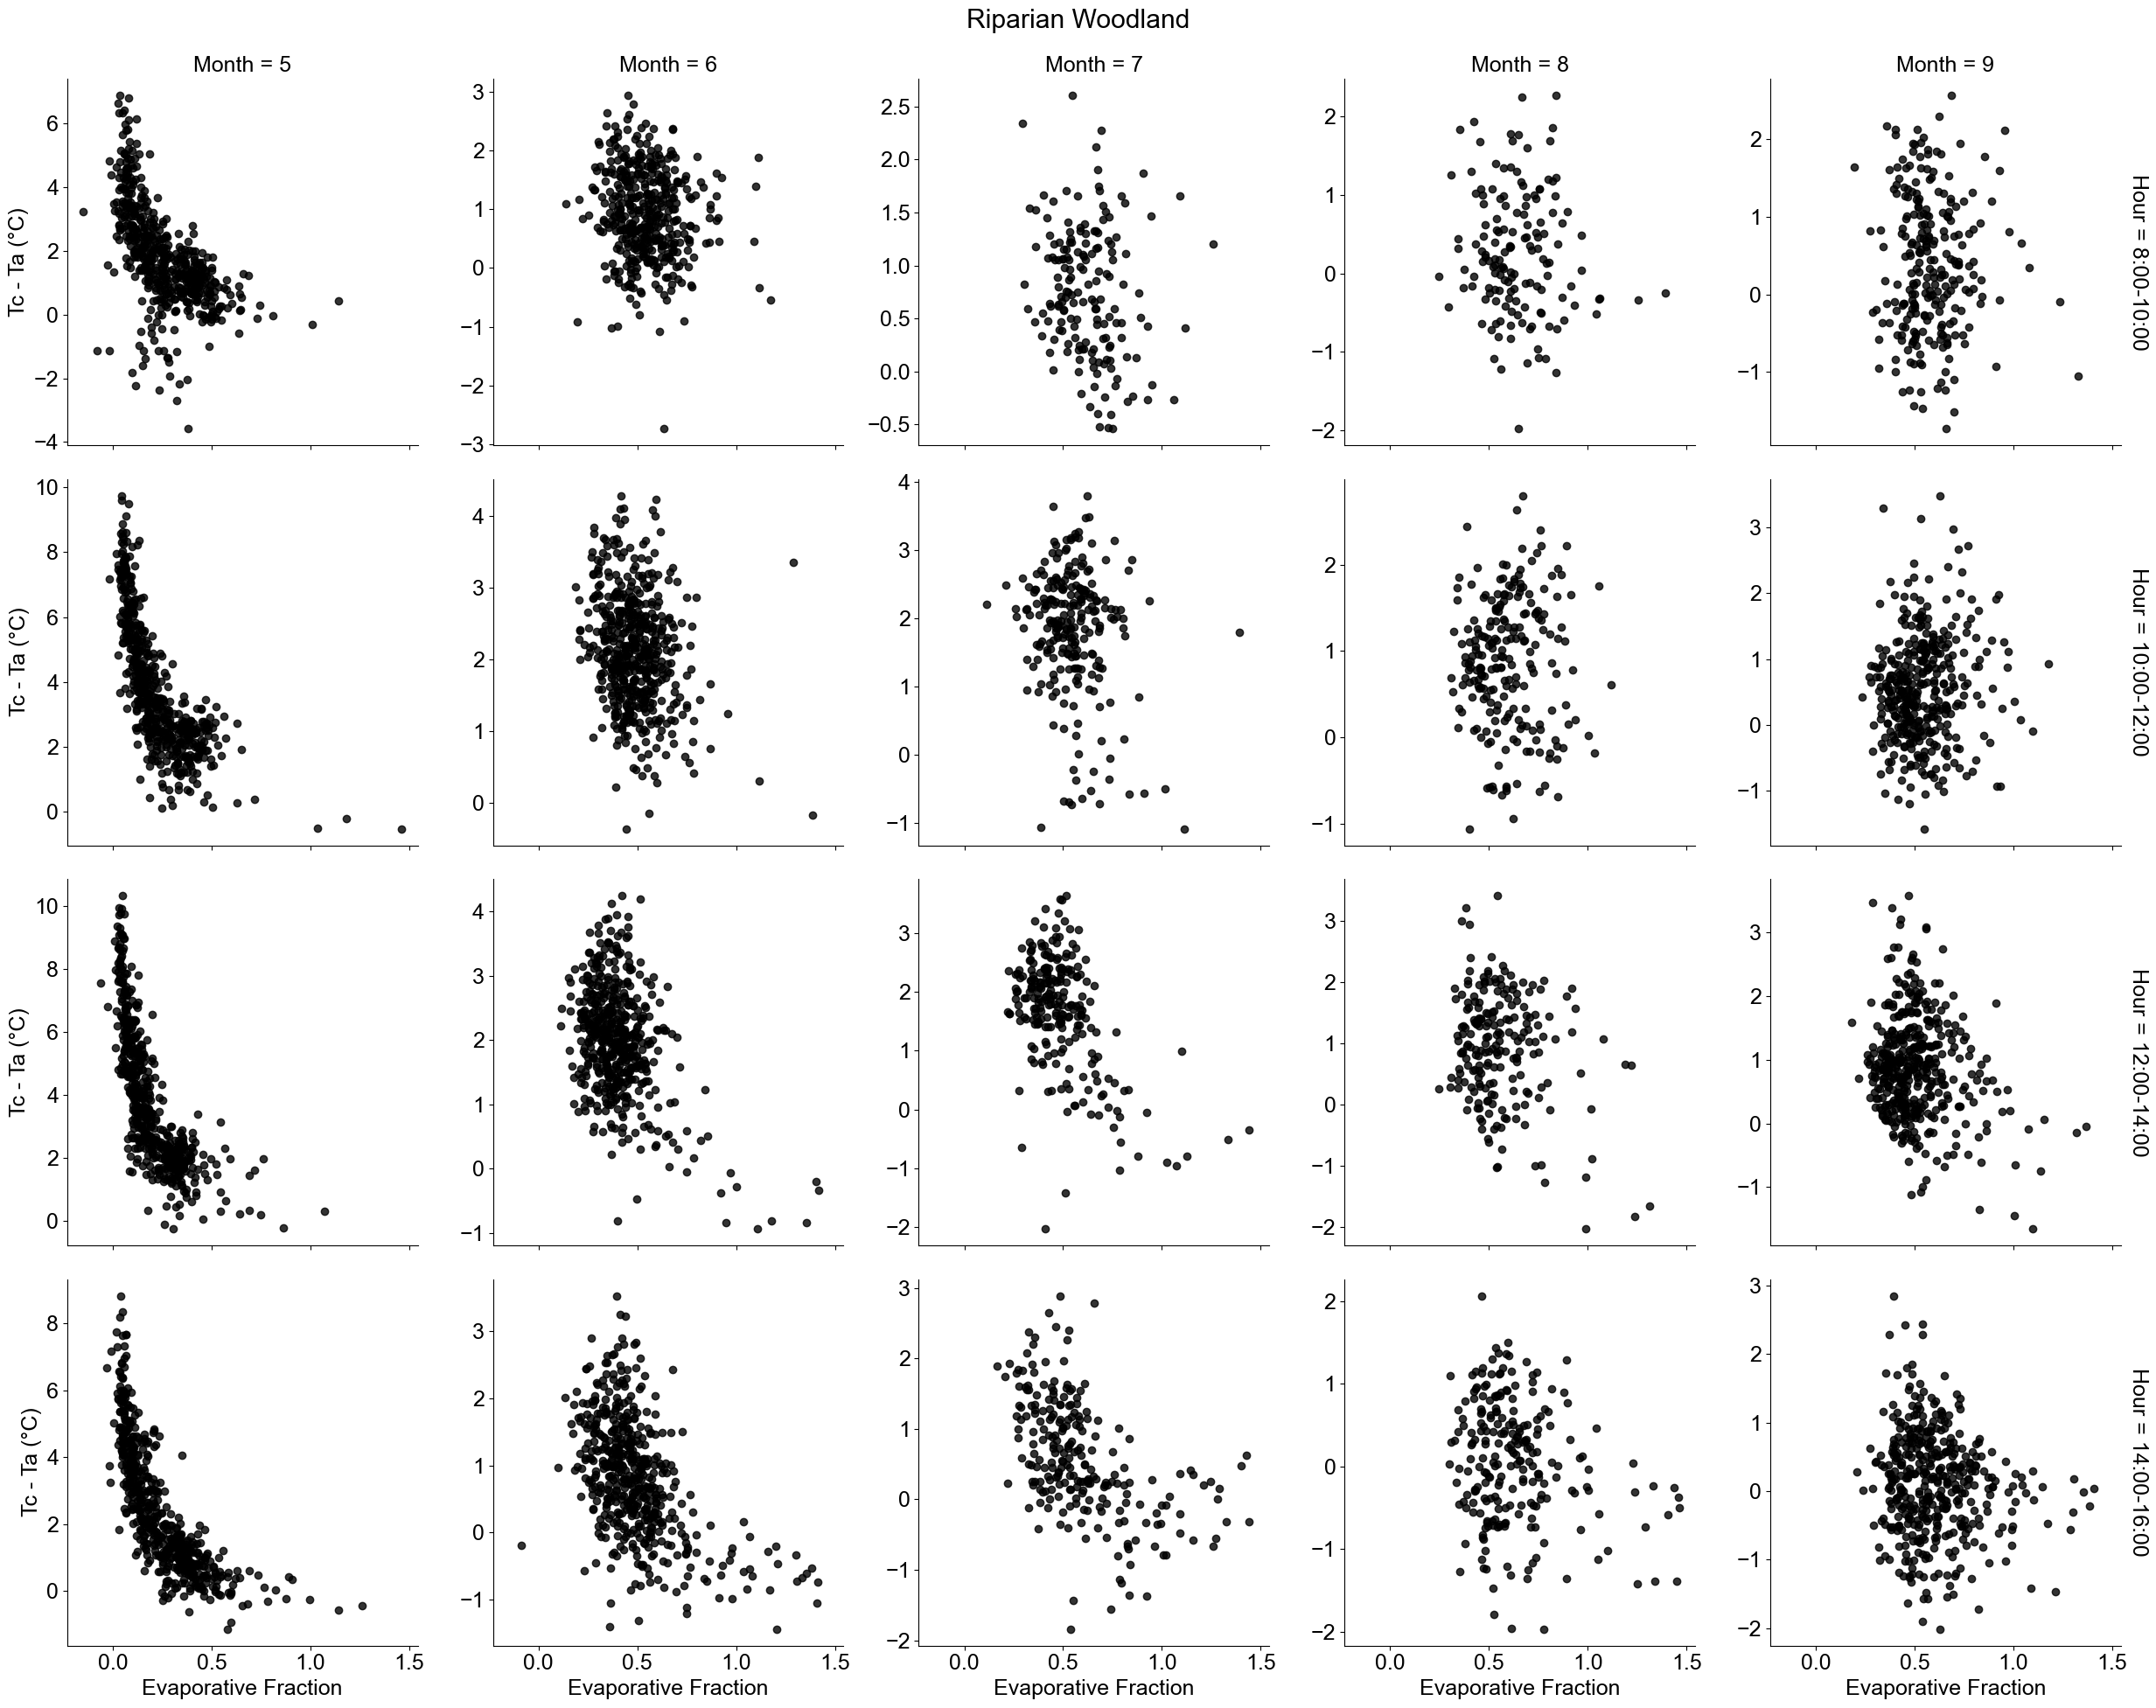

In [153]:
plt.rcParams['font.family'] = 'Arial'
plt.rc('font', size=18)   # controls default text sizes
plt.rc('axes', titlesize=18)  # fontsize of the axes title

b = sns.lmplot(CMW_plt_vals, x = 'Evap_Frac', y = 'IR_tc_ta', row = 'Hour', col = 'Month', facet_kws=dict(sharey=False, sharex = True, margin_titles = True), scatter_kws = {'color': 'black'}, fit_reg = False)
b.set_xlabels("Evaporative Fraction")
b.set_ylabels("Tc - Ta (°C)")
plt.subplots_adjust(top=0.94) # adjust the Figure in rp
plt.suptitle('Riparian Woodland')
plt.show()

In [154]:
CMW_ef_corr = (CMW_plt_vals[['Evap_Frac', 'IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
 .corr()
 .reset_index()
 .groupby(['month', 'hour'])
 .first()
 .reset_index()
 .pivot(index = 'hour', columns = 'month', values = 'IR_tc_ta')
 .round(3))

In [155]:
CMW_ef_corr

month,5,6,7,8,9
hour,,,,,
4.0,-0.591,-0.131,-0.183,-0.104,-0.044
5.0,-0.723,-0.241,-0.203,0.000,0.094
6.0,-0.740,-0.438,-0.521,-0.264,-0.212
7.0,-0.768,-0.517,-0.525,-0.223,-0.144


In [156]:
(CMW_plt_vals[['Evap_Frac', 'IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
 .corr()
 .reset_index()
 .groupby(['month', 'hour'])
 .first()
 .drop(['level_2'], axis = 1)
 .reset_index().groupby(['month']).mean())

,hour,Evap_Frac,IR_tc_ta
month,,,
5,5.5,1.0,-0.705417
6,5.5,1.0,-0.331821
7,5.5,1.0,-0.357908
8,5.5,1.0,-0.147676
9,5.5,1.0,-0.076596


In [157]:
min_tc = (CMW_plt_vals[['IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
          .min()
          .reset_index()
          .pivot(index = 'hour', columns = 'month', values = 'IR_tc_ta'))

In [158]:
max_tc = (CMW_plt_vals[['IR_tc_ta', 'hour', 'month']].groupby(['hour', 'month'])
          .max()
          .reset_index()
          .pivot(index = 'hour', columns = 'month', values = 'IR_tc_ta'))

In [159]:
max_tc - min_tc

month,5,6,7,8,9
hour,,,,,
4.0,10.4640,5.6751,3.145,4.2500,4.2951
5.0,10.2702,4.6450,4.880,3.8600,5.0550
6.0,10.6002,5.1850,5.660,5.4401,5.2351
7.0,9.9729,4.9600,4.730,4.0352,4.8601
